In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

from IPython.display import display


iterations = 24 # iterations of walk-forward validation

# Prepration

In [2]:
# Reading 4 CSV format files containing 6 different SPI time scales and a date column.
# Skipping the first 7 rows as they contain headers and file information.
# File paths for datasets related to different geographical areas in Devon,
# each named after the river present in that area.

dataset_path_exeter = r"C:\Users\ADMIN\JupyterNotebook\Drought\DataSet\nhmp-spi-ihu-area-45.csv"
dataset_path_dart = r"C:\Users\ADMIN\JupyterNotebook\Drought\DataSet\nhmp-spi-ihu-area-46.csv"
dataset_path_tamar = r"C:\Users\ADMIN\JupyterNotebook\Drought\DataSet\nhmp-spi-ihu-area-47.csv"
dataset_path_taw_torridge = r"C:\Users\ADMIN\JupyterNotebook\Drought\DataSet\nhmp-spi-ihu-area-50.csv"

df_exeter = pd.read_csv(dataset_path_exeter, parse_dates=['date'], skiprows=7)
df_dart = pd.read_csv(dataset_path_dart, parse_dates=['date'], skiprows=7)
df_tamar = pd.read_csv(dataset_path_tamar, parse_dates=['date'], skiprows=7)
df_taw_torridge = pd.read_csv(dataset_path_taw_torridge, parse_dates=['date'], skiprows=7)

# Removing the 'spi-9' column from each dataframe, as it contains only NA values.

df_exeter.drop(columns=['spi-9'], inplace=True)
df_dart.drop(columns=['spi-9'], inplace=True)
df_tamar.drop(columns=['spi-9'], inplace=True)
df_taw_torridge.drop(columns=['spi-9'], inplace=True)


In [3]:
# Create a dictionary of data frames to facilitate the application of the models and plot on them.
area = {'Exeter':df_exeter, 'Dart':df_dart, 'Tamar':df_tamar, 'Taw and Torridge':df_taw_torridge}

In [4]:
# The presence of NA (Not Available) values in the first 30 rows of each SPI (Standardized Precipitation Index)
# column is not indicative of data loss. Instead, it is a natural occurrence due to the nature of SPI calculation
# and the corresponding time scales.

# The SPI calculation involves computing the probability of precipitation for a specific time scale, 
# such as SPI-3 (3-month SPI) and SPI-6 (6-month SPI), by comparing the observed precipitation with a 
# specific historical distribution. The calculation relies on a sliding window of data, where the length
# of the window is determined by the time scale. For example, SPI-3 uses a 3-month sliding window, and 
# SPI-6 uses a 6-month sliding window.

# In the first 30 rows of the DataFrame, there are not enough prior data points available to compute the SPI 
# for larger time scales (e.g., SPI-6), resulting in NA values. As we move down the DataFrame and accumulate 
# more data points, the SPI values for larger time scales will gradually become available.

# This behavior is an inherent characteristic of the SPI calculation and is expected when dealing with 
# smaller data sets or at the beginning of the time series. It does not indicate any data loss or error 
# in the calculation; rather, it reflects the nature of the SPI computation and the temporal dependencies 
# inherent in its formulation.

print(df_exeter.head(30))

         date  spi-1  spi-3  spi-6  spi-12  spi-18  spi-24
0  1862-01-01 -0.362    NaN    NaN     NaN     NaN     NaN
1  1862-02-01 -1.509    NaN    NaN     NaN     NaN     NaN
2  1862-03-01  1.002 -0.592    NaN     NaN     NaN     NaN
3  1862-04-01  0.074 -0.433    NaN     NaN     NaN     NaN
4  1862-05-01  0.396  0.705    NaN     NaN     NaN     NaN
5  1862-06-01  0.352  0.256 -0.436     NaN     NaN     NaN
6  1862-07-01  0.456  0.471 -0.020     NaN     NaN     NaN
7  1862-08-01 -0.841 -0.207  0.284     NaN     NaN     NaN
8  1862-09-01 -1.239 -1.330 -0.752     NaN     NaN     NaN
9  1862-10-01  1.064 -0.298  0.012     NaN     NaN     NaN
10 1862-11-01 -2.802 -0.990 -1.140     NaN     NaN     NaN
11 1862-12-01 -0.721 -0.882 -1.531  -1.494     NaN     NaN
12 1863-01-01  0.559 -1.297 -1.194  -1.039     NaN     NaN
13 1863-02-01 -0.781 -0.519 -1.098  -0.832     NaN     NaN
14 1863-03-01 -0.604 -0.455 -1.021  -1.297     NaN     NaN
15 1863-04-01 -0.135 -1.331 -1.825  -1.306     NaN     N

In [5]:
print('* total rows of data frame before removing NA:\n')
for key, value in area.items():
    print(f"Total {key} rows count: {len(value)}")

# i expect that, upon removing 'NA' values, we will proceed to delete the first 23 rows.
print('\n')
for value in area.values():
    value.dropna(inplace=True)
    value.reset_index(drop=True, inplace=True)

print('* total rows of data frame after removing NA:\n')
for key, value in area.items():
    print(f"Total {key} rows count: {len(value)}")

* total rows of data frame before removing NA:

Total Exeter rows count: 1937
Total Dart rows count: 1937
Total Tamar rows count: 1937
Total Taw and Torridge rows count: 1937


* total rows of data frame after removing NA:

Total Exeter rows count: 1914
Total Dart rows count: 1914
Total Tamar rows count: 1914
Total Taw and Torridge rows count: 1914


In [6]:
for key, value in area.items():
    print('\n', key, ':\n')
    print(value.head(5))


 Exeter :

        date  spi-1  spi-3  spi-6  spi-12  spi-18  spi-24
0 1863-12-01 -0.484  0.511  0.663   0.683  -0.355  -0.589
1 1864-01-01 -0.966 -1.090  0.440   0.133  -0.668  -0.616
2 1864-02-01 -0.548 -1.194  0.062   0.184  -0.636  -0.444
3 1864-03-01  0.516 -0.846 -0.236   0.427  -0.319  -0.557
4 1864-04-01  0.042 -0.329 -1.086   0.473  -0.683  -0.551

 Dart :

        date  spi-1  spi-3  spi-6  spi-12  spi-18  spi-24
0 1863-12-01 -0.133  0.396  0.704   0.564  -0.469  -0.748
1 1864-01-01 -0.729 -0.847  0.477   0.182  -0.672  -0.733
2 1864-02-01 -0.362 -0.780  0.095   0.276  -0.594  -0.542
3 1864-03-01 -0.370 -1.127 -0.508   0.265  -0.502  -0.845
4 1864-04-01 -0.615 -1.147 -1.395   0.164  -0.969  -0.894

 Tamar :

        date  spi-1  spi-3  spi-6  spi-12  spi-18  spi-24
0 1863-12-01  0.037  0.227  0.690   0.668  -0.057  -0.205
1 1864-01-01 -0.506 -0.695  0.633   0.286  -0.265  -0.282
2 1864-02-01 -0.327 -0.587  0.156   0.375  -0.234  -0.123
3 1864-03-01 -1.189 -1.326 -0.766   0.1

In [7]:
for key, value in area.items():
    print(key, ':\n')
    print(value.info(), '\n')
    print('=' * 40)

Exeter :

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1914 entries, 0 to 1913
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    1914 non-null   datetime64[ns]
 1   spi-1   1914 non-null   float64       
 2   spi-3   1914 non-null   float64       
 3   spi-6   1914 non-null   float64       
 4   spi-12  1914 non-null   float64       
 5   spi-18  1914 non-null   float64       
 6   spi-24  1914 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 104.8 KB
None 

Dart :

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1914 entries, 0 to 1913
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    1914 non-null   datetime64[ns]
 1   spi-1   1914 non-null   float64       
 2   spi-3   1914 non-null   float64       
 3   spi-6   1914 non-null   float64       
 4   spi-12  1914 non-null   float64      

In [8]:
for key, value in area.items():
    print(key, ': ')
    display(value.describe())

Exeter : 


,spi-1,spi-3,spi-6,spi-12,spi-18,spi-24
count,1914.000000,1914.000000,1914.000000,1914.000000,1914.000000,1914.000000
mean,-0.003462,0.021282,0.037056,0.049368,0.056670,0.064122
std,1.095961,1.095356,1.130120,1.158715,1.144805,1.107952
min,-4.309000,-4.740000,-3.509000,-4.115000,-3.988000,-2.933000
25%,-0.659750,-0.688250,-0.702500,-0.722750,-0.745000,-0.777250
50%,0.088500,0.068000,0.059500,0.071000,0.023500,0.007000
75%,0.732000,0.769750,0.781500,0.796000,0.825500,0.869750
max,2.995000,3.401000,3.492000,3.942000,3.397000,3.218000


Dart : 


,spi-1,spi-3,spi-6,spi-12,spi-18,spi-24
count,1914.000000,1914.000000,1914.000000,1914.00000,1914.000000,1914.000000
mean,-0.048708,-0.060071,-0.084666,-0.12973,-0.155682,-0.175592
std,1.093940,1.091187,1.135904,1.19013,1.198207,1.186895
min,-4.553000,-4.358000,-3.962000,-4.06800,-4.368000,-4.476000
25%,-0.691000,-0.771500,-0.861750,-0.94400,-0.988750,-1.084000
50%,0.045000,-0.039500,-0.045500,-0.06450,-0.118500,-0.158500
75%,0.702750,0.704250,0.691750,0.69125,0.684750,0.677500
max,2.939000,3.308000,3.265000,3.41800,3.525000,3.189000


Tamar : 


,spi-1,spi-3,spi-6,spi-12,spi-18,spi-24
count,1914.000000,1914.000000,1914.000000,1914.000000,1914.000000,1914.000000
mean,-0.030965,-0.039046,-0.048175,-0.062179,-0.076493,-0.084582
std,1.069796,1.065718,1.101683,1.127414,1.124625,1.115639
min,-4.218000,-4.871000,-3.934000,-3.673000,-3.742000,-3.632000
25%,-0.665000,-0.723750,-0.781000,-0.846750,-0.921000,-0.930000
50%,0.046500,0.002500,-0.027000,-0.029500,-0.084500,-0.124500
75%,0.717750,0.725500,0.718000,0.695000,0.696750,0.735750
max,2.936000,3.532000,2.950000,3.082000,2.980000,2.912000


Taw and Torridge : 


,spi-1,spi-3,spi-6,spi-12,spi-18,spi-24
count,1914.000000,1914.000000,1914.000000,1914.000000,1914.000000,1914.000000
mean,-0.033310,-0.033652,-0.039569,-0.048627,-0.060948,-0.070351
std,1.077197,1.047747,1.072279,1.050456,1.031707,1.006947
min,-4.614000,-4.652000,-3.851000,-3.137000,-3.397000,-2.707000
25%,-0.698250,-0.718000,-0.754500,-0.791250,-0.823750,-0.834750
50%,0.042000,-0.028500,-0.007500,-0.070000,-0.061000,-0.070500
75%,0.721500,0.703750,0.696750,0.674000,0.668750,0.655000
max,2.809000,3.252000,2.911000,3.134000,2.815000,2.896000


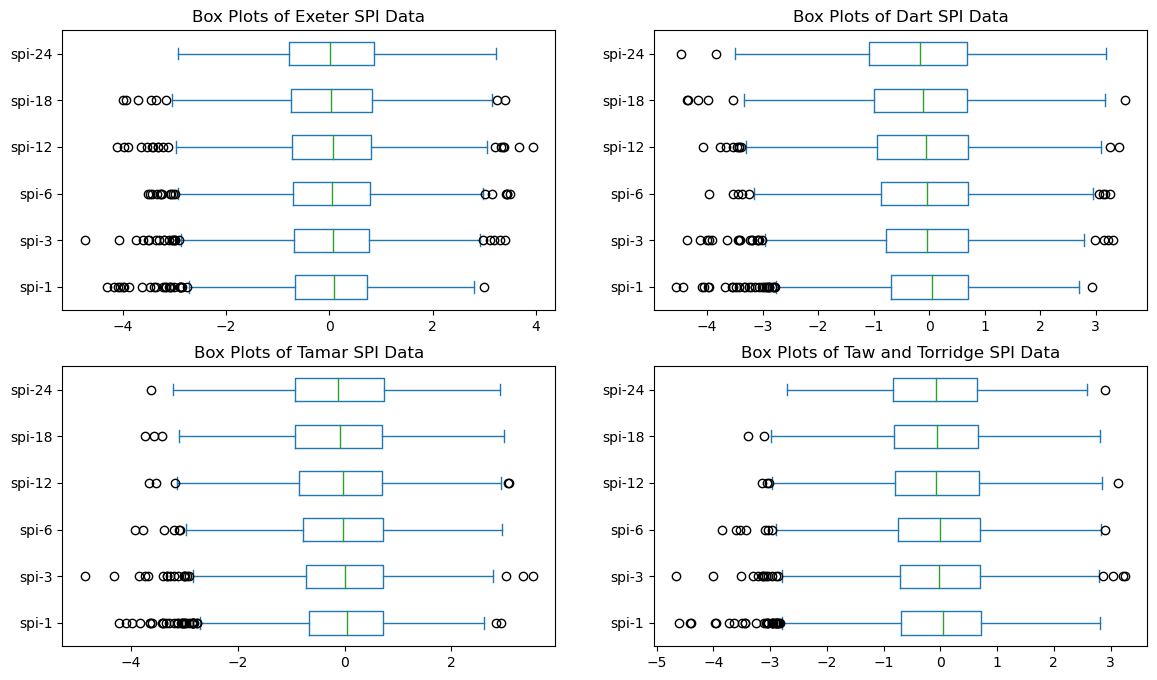

In [9]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 8))
grid = [ax1, ax2, ax3, ax4]
for i,(key, value) in enumerate(area.items()):
    value.plot(kind='box', vert=False, ax=grid[i])
    grid[i].set_title(f'Box Plots of {key} SPI Data')

# df_exeter.plot(kind='box', vert=False, ax=ax1)
# df_dart.plot(kind='box', vert=False, ax=ax2)
# df_tamar.plot(kind='box', vert=False, ax=ax3)
# df_taw_torridge.plot(kind='box', vert=False, ax=ax4)
# ax1.set_title('Box Plots of SPI Data')
# plt.title('Box Plots of SPI Data')
# plt.xlabel('SPI Value')
# plt.ylabel('SPI time scale')
# plt.show()

as we can see in plot above when using the Standardized Precipitation Index to analyze precipitation data over different accumulation periods (SPI-1 for 1 month, SPI-3 for 3 months and ...), the SPI-24 is expected to have fewer outlier values. In other words, SPI-24 is likely to show a more stable and consistent pattern of precipitation compared to shorter accumulation periods. The reason for this anticipation could be that the longer 24-month accumulation period smooths out the variations in short-term weather fluctuations, resulting in a more representative and robust representation of the overall precipitation conditions.

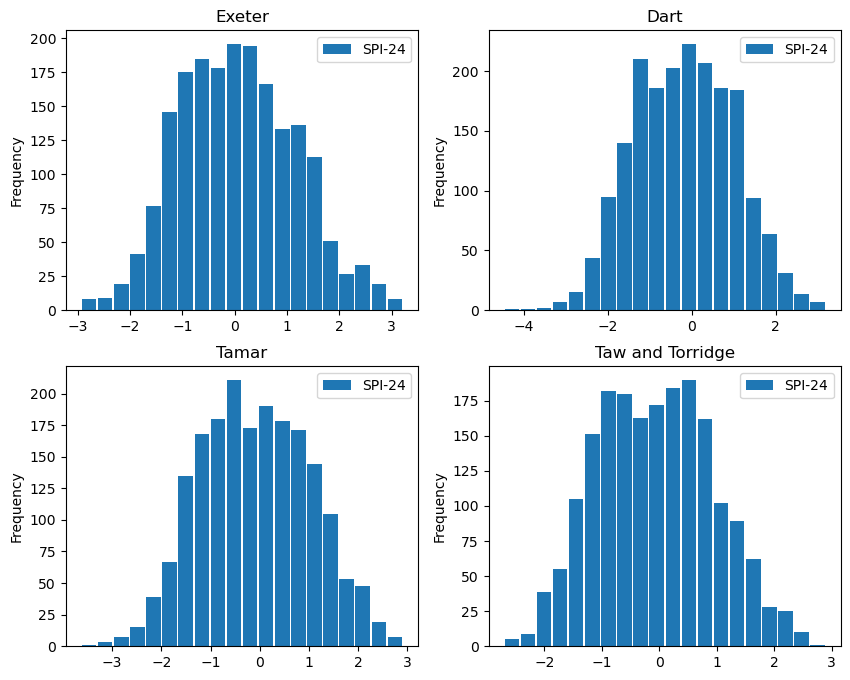

In [10]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(10, 8))
grid = [ax1, ax2, ax3, ax4]
for i, (key, value) in enumerate(area.items()):
    value['spi-24'].plot(kind='hist', bins=20, rwidth=0.9, ax=grid[i], label='SPI-24')
    grid[i].set_title(key)
    grid[i].legend()
plt.show()
    
    


plot above shows the distribution of values tends to follow a roughly normal or Gaussian distribution centered around 0.

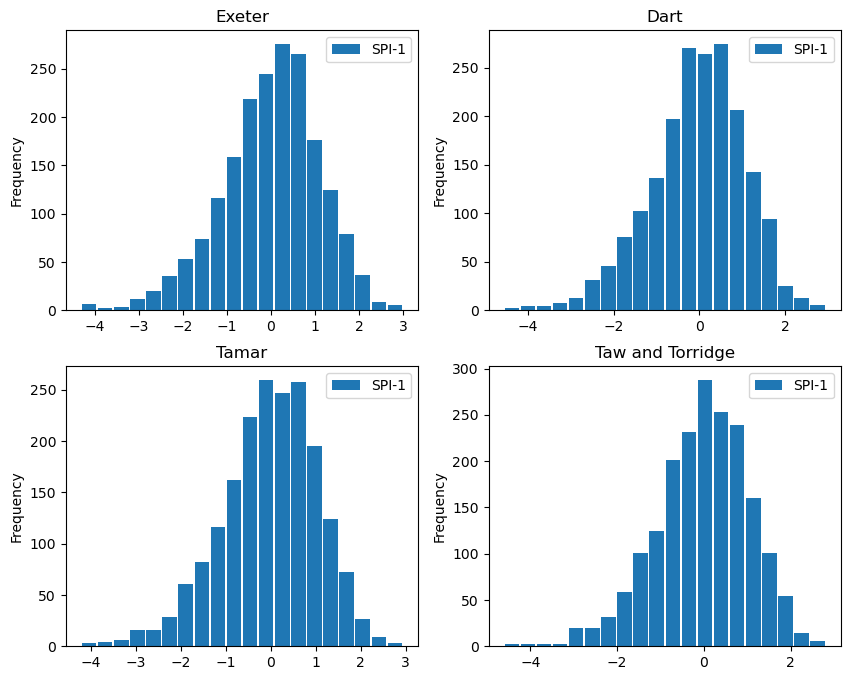

In [11]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(10, 8))
grid = [ax1, ax2, ax3, ax4]
for i, (key, value) in enumerate(area.items()):
    value['spi-1'].plot(kind='hist', bins=20, rwidth=0.9, ax=grid[i], label='SPI-1')
    grid[i].set_title(key)
    grid[i].legend()
plt.show()

while spi-1 tends to skew to left (plot above)

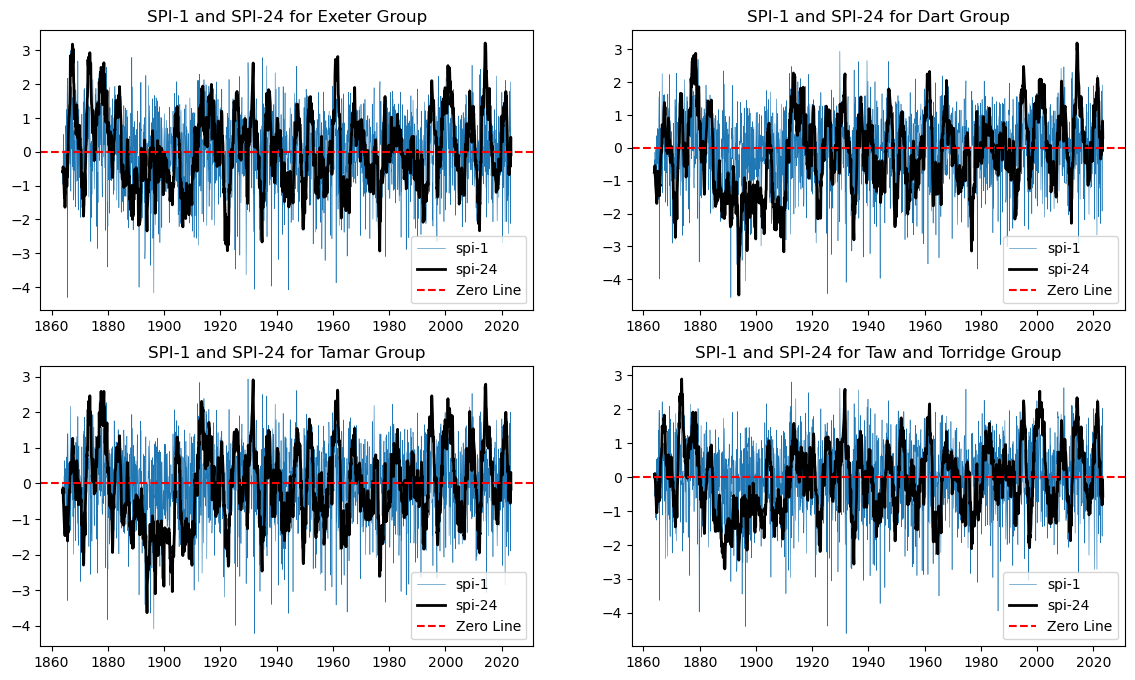

In [12]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(14, 8))
grid = [ax1, ax2, ax3, ax4]
for i, (key, value) in enumerate(area.items()):
    grid[i].plot(value.date, value['spi-1'], label='spi-1', linewidth=0.4)
    grid[i].plot(value.date, value['spi-24'], label='spi-24', linewidth=2, color='black')
    grid[i].axhline(y=0, color='red', linestyle='--', label='Zero Line')
    grid[i].legend()
    grid[i].set_title(f'SPI-1 and SPI-24 for {key} Group')
    
plt.show()

From the plot above, we can observe that during the period between 1890 and 1910, while the other areas experienced drier than normal years, Exeter exhibited a comparatively wetter condition than the other three areas (though not entirely wetter than normal).

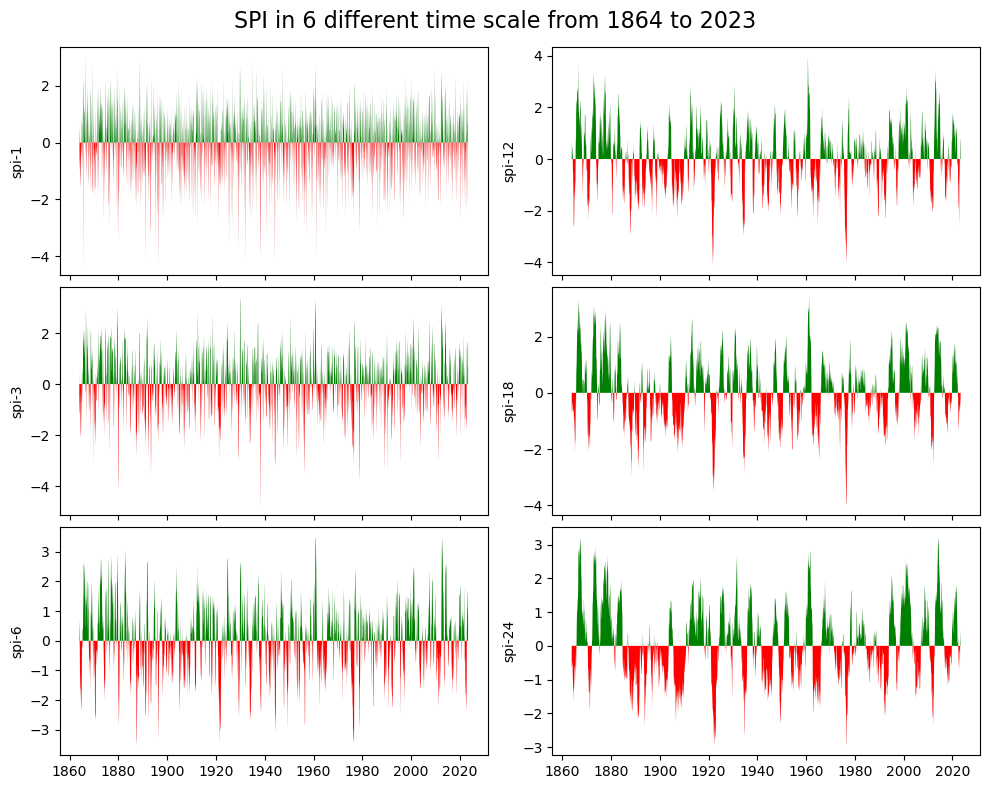

In [13]:

# compare the severity and duration of drought and wet periods using SPI in different time scales.
# plot the SPI values in 6 different time scales: SPI-1, SPI-3, SPI-6, SPI-12, SPI-18, and SPI-24.
# Each subplot represents one time scale and shows the SPI values as a line plot.
# The area between the line plot and the x-axis is filled with colors to indicate drought and wet periods.
# Drought periods are filled with red color, while wet periods are filled with green color.
# The x-axis represents the time index of the SPI values.
# The y-axis represents the corresponding SPI values for each time scale.
# By comparing the plots, it is possible to observe and analyze the severity and duration of drought and wet periods in different time scales.
fig, ((ax1, ax4), (ax2, ax5), (ax3, ax6)) = plt.subplots(3, 2, figsize=(10, 8)) 
grid = [ax1, ax2, ax3, ax4, ax5, ax6]
for i ,j in enumerate(df_exeter.columns[1:7]):
    grid[i].plot(df_exeter['date'], df_exeter[j] ,color='black', linewidth=0.01)
    grid[i].fill_between(df_exeter['date'], df_exeter[j], 0, where=df_exeter[j] >= 0, facecolor='green', interpolate=True)
    grid[i].fill_between(df_exeter['date'], df_exeter[j], 0, where=df_exeter[j] < 0, facecolor='red', interpolate=True)
    grid[i].set_ylabel(j)
    
    if j not in ('spi-6', 'spi-24'):
        grid[i].set_xlabel('')
        grid[i].set_xticklabels([])
fig.suptitle('SPI in 6 different time scale from 1864 to 2023', fontsize=16)
plt.tight_layout()
plt.subplots_adjust(hspace=0.05)
plt.show()



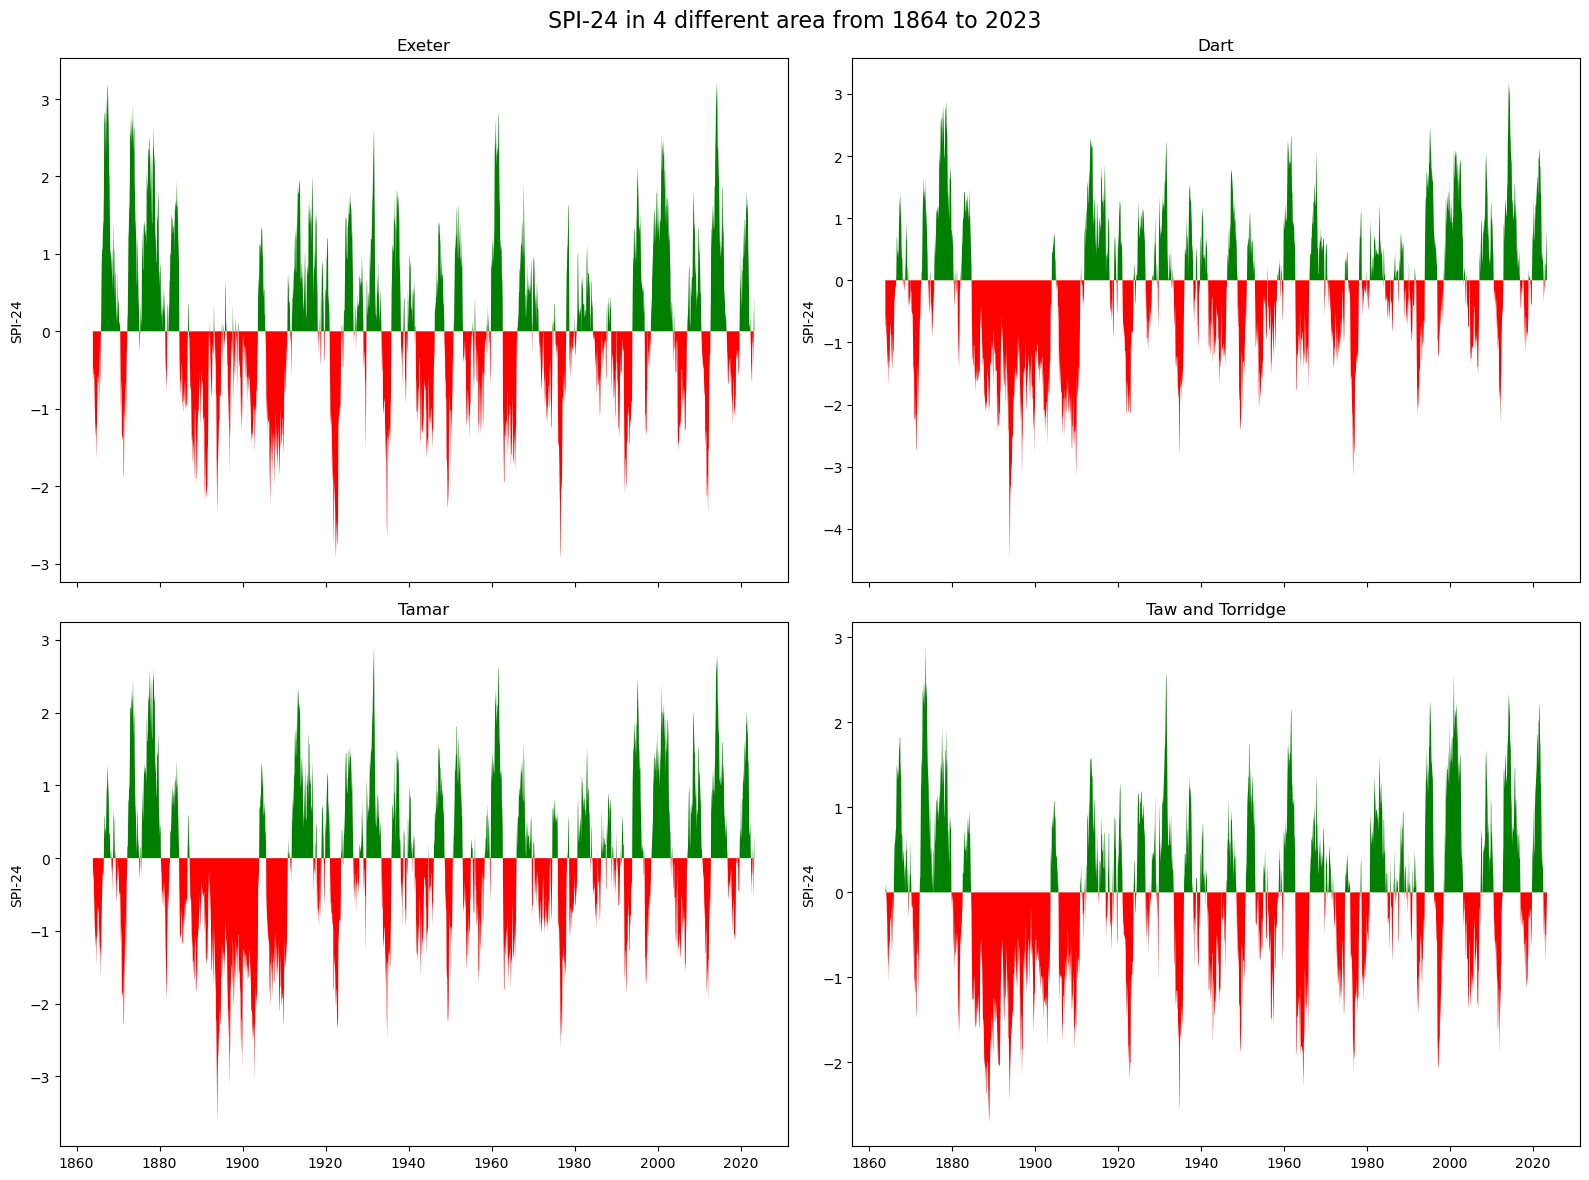

In [14]:
# Plot SPI-24 for four areas.
# The red color (below the zero line) indicates periods drier than normal, 
# and the green color (above the zero line) indicates periods wetter than normal.

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(16, 12))
grid = [ax1, ax2, ax3, ax4]
var = 'spi-24'
for i, (key, value) in enumerate(area.items()):
    
    grid[i].plot(value['date'], value[var], color='black', linewidth=0.01)
    
    grid[i].fill_between(value['date'],  
                         value[var], 0, 
                         where=value[var] >= 0, 
                         facecolor='green', 
                         interpolate=True)
    
    grid[i].fill_between(value['date'], 
                         value[var], 0, 
                         where=value[var] < 0, 
                         facecolor='red', 
                         interpolate=True)
    grid[i].set_ylabel('SPI-24')
    grid[i].set_title(key)
    if i not in [2, 3]:
        grid[i].set_xticklabels([])
        grid[i].set_xlabel('') 
    
fig.suptitle('SPI-24 in 4 different area from 1864 to 2023', fontsize=16)
plt.tight_layout()
# plt.subplots_adjust(hspace=0.05)
plt.show()
    



# ARIMA Model

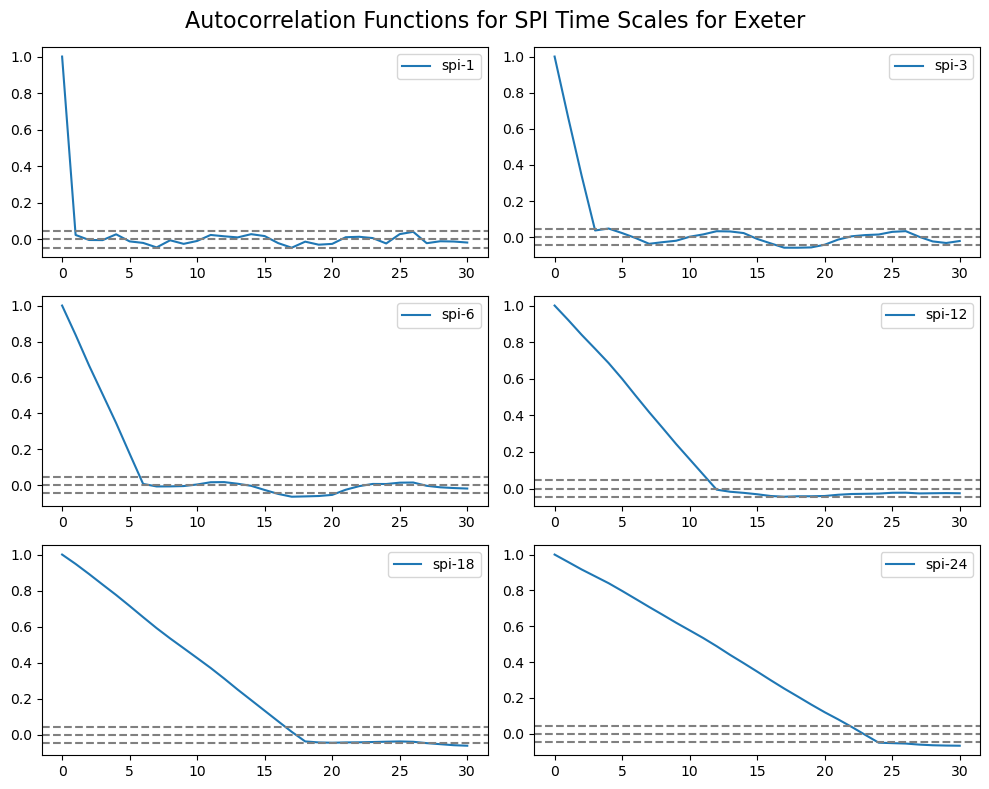

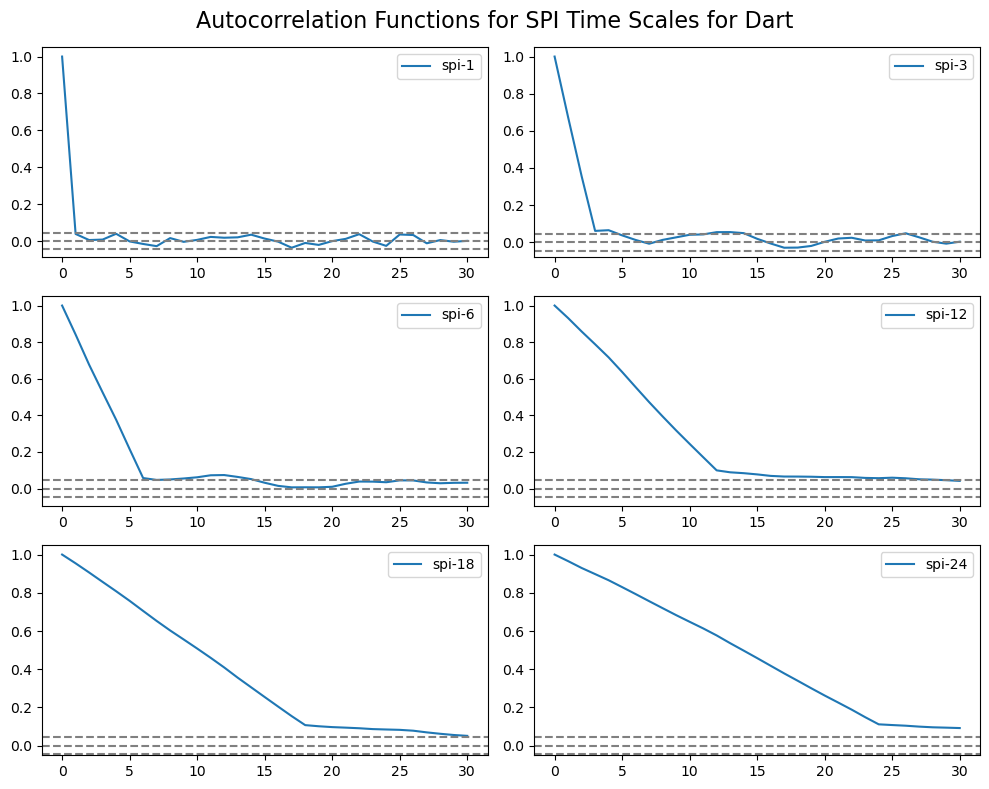

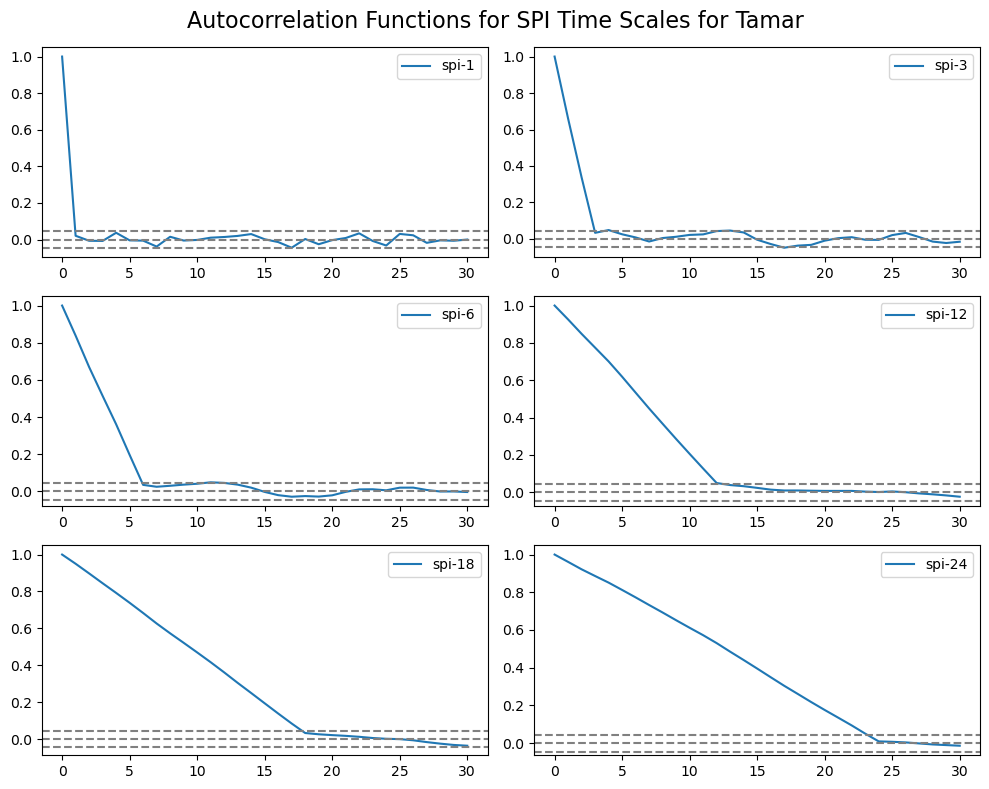

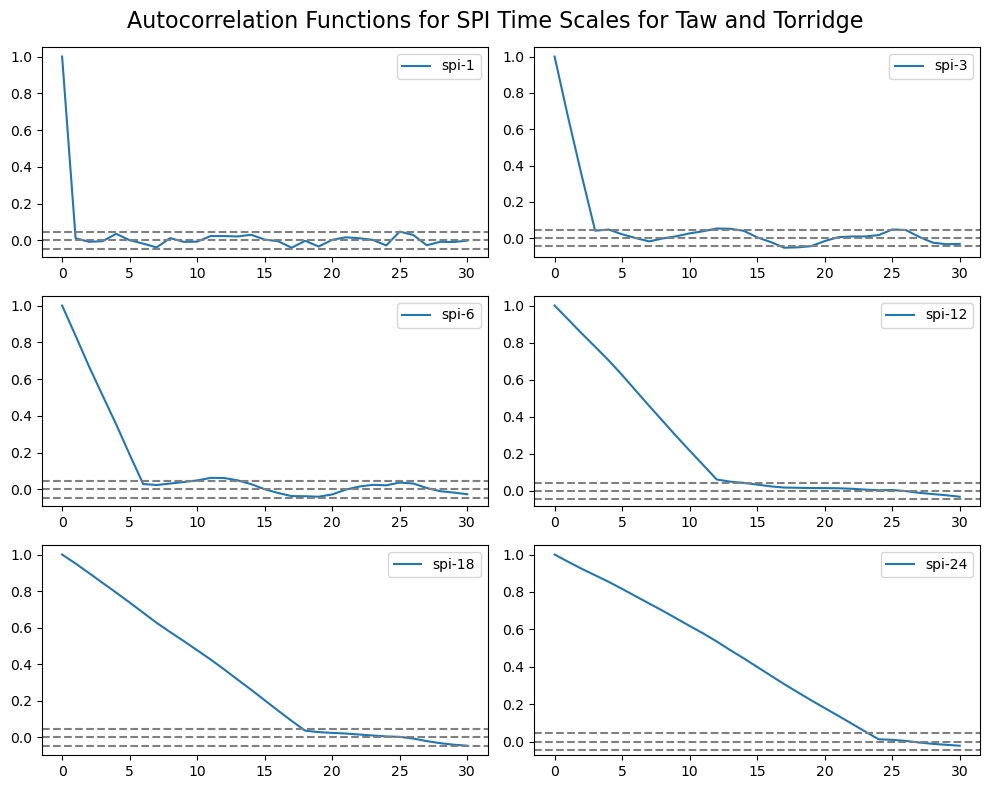

In [15]:
# This code calculates and visualizes the autocorrelation functions (ACFs) for different SPI time scales.
# By plotting the ACFs with varying SPI time scales, we can observe the relationship between autocorrelation and the lag.
    # This visualization helps establish a rule indicating that the selection 
    # of the 'p' parameter (representing AR) in the order() function is influenced 
    # by the autocorrelation and the SPI time scale.


# Calculate the ACF for each SPI time scale with a maximum lag of 30 for four area in Devon
df_col_name = df_exeter.columns[1:7]
for key, value in area.items():
    lag_acf = []
    for i in df_col_name:
        acf_values = acf(value[i], nlags=30)
        lag_acf.append(acf_values)


    fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(10, 8))
    grid = [ax1, ax2, ax3, ax4, ax5, ax6]
    for i, j in enumerate(df_col_name):
        grid[i].plot(lag_acf[i], label = j)
        grid[i].axhline(y=0, linestyle='--', color='gray')
        grid[i].axhline(y=-1.96/np.sqrt(len(value)), linestyle='--', color='gray')
        grid[i].axhline(y=1.96/np.sqrt(len(value)), linestyle='--', color='gray')
        grid[i].legend()
    
    fig.suptitle(f'Autocorrelation Functions for SPI Time Scales for {key}', fontsize=16)
    plt.tight_layout()
    plt.show()
    


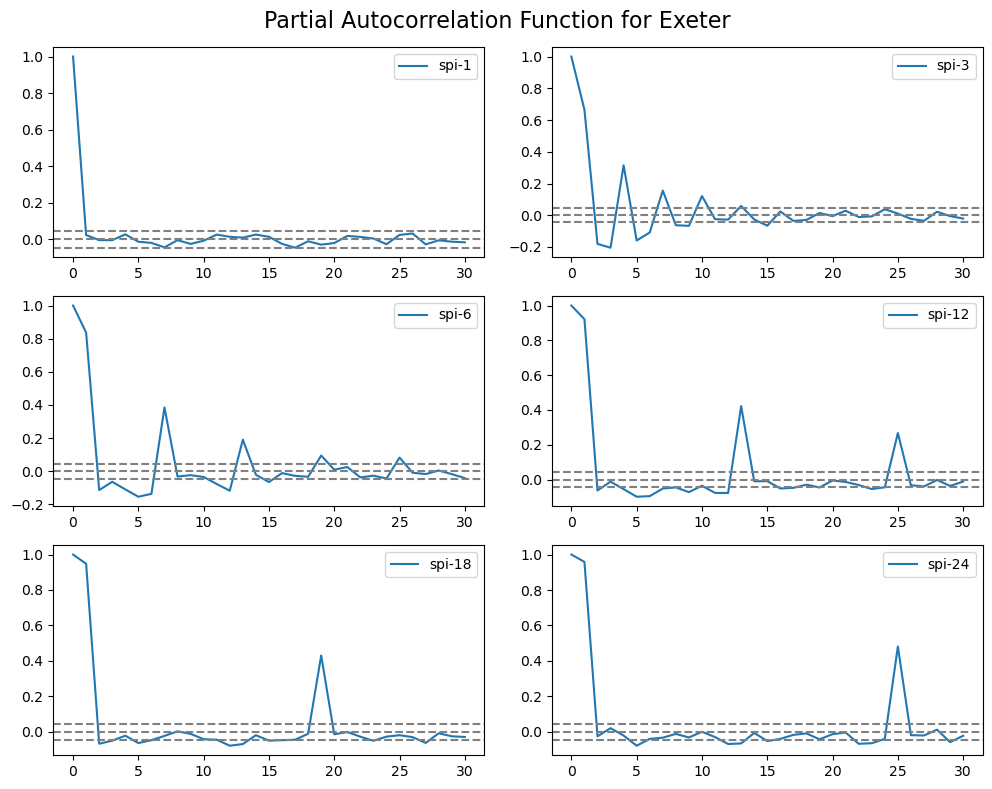

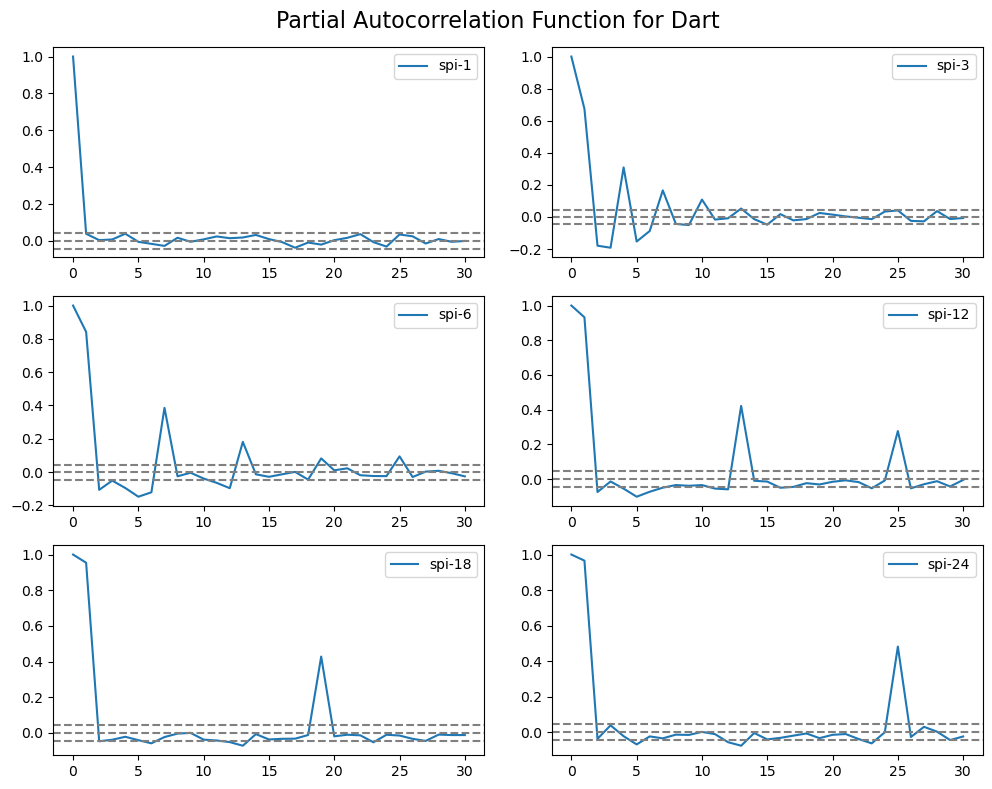

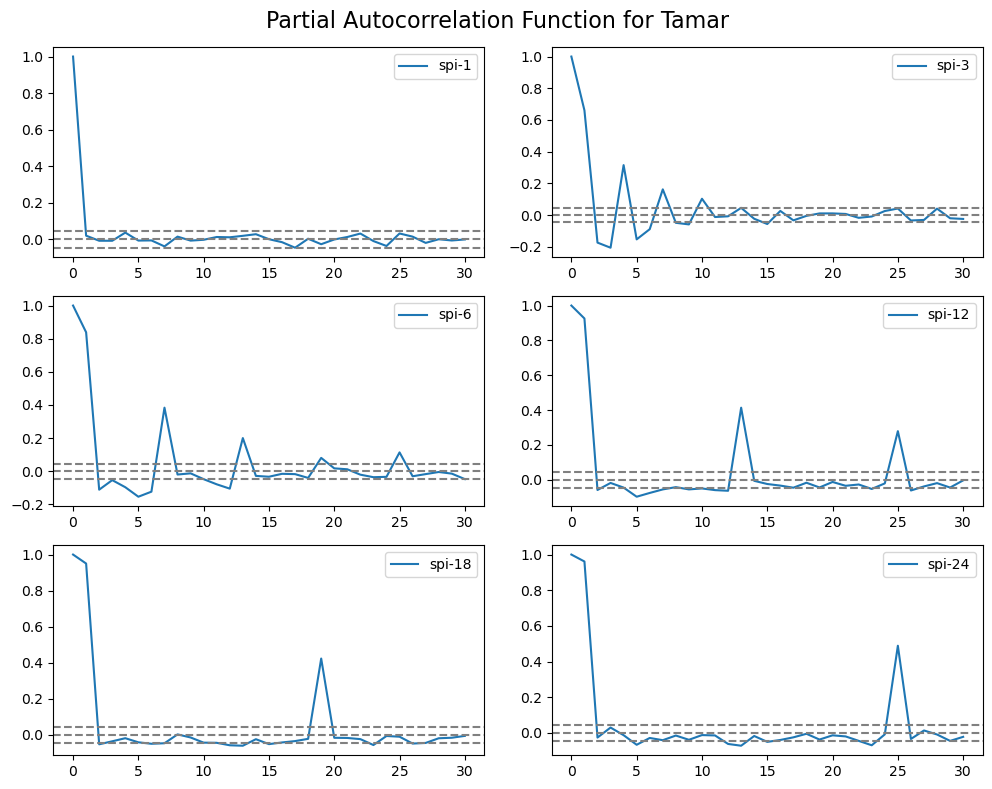

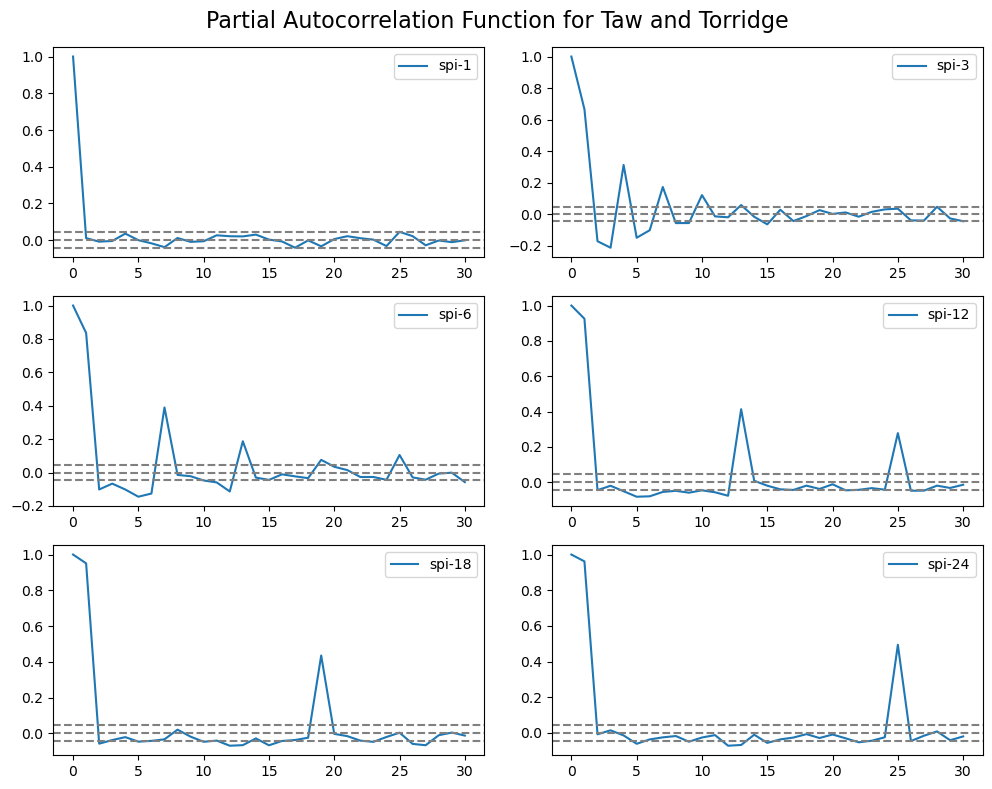

In [16]:
# Calculate the ACF for each SPI time scale with a maximum lag of 30 for four area in Devon
df_col_name = df_exeter.columns[1:7]
for key, value in area.items():
    lag_pacf = []
    for i in df_col_name:
        pacf_values = pacf(value[i], nlags=30, method='ols')
        lag_pacf.append(pacf_values)


    fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(10, 8))
    grid = [ax1, ax2, ax3, ax4, ax5, ax6]
    for i, j in enumerate(df_col_name):
        grid[i].plot(lag_pacf[i], label = j)
        grid[i].axhline(y=0, linestyle='--', color='gray')
        grid[i].axhline(y=-1.96/np.sqrt(len(value)), linestyle='--', color='gray')
        grid[i].axhline(y=1.96/np.sqrt(len(value)), linestyle='--', color='gray')
        grid[i].legend()
    
    fig.suptitle(f'Partial Autocorrelation Function for {key}', fontsize=16)
    plt.tight_layout()
    plt.show()
    

In [17]:
#split to test and train and make model based on train
# create model for each area
spi = {}
arima_train_model = {}
arima_result = {}
train = {}
test = {}

for key, value in area.items():
    spi[key] = pd.Series(value['spi-24'].values, 
                         index=pd.date_range(start=value.date[0], 
                                             periods=len(value), 
                                             freq='MS'))
    size = int(len(spi[key]) * 0.8)
    train[key], test[key] = spi[key][:size], spi[key][size:]
    arima_train_model[key] = ARIMA(train[key], order=(2, 0, 24))
    arima_result[key] = arima_train_model[key].fit()


C:\Users\ADMIN\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ADMIN\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ADMIN\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ADMIN\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


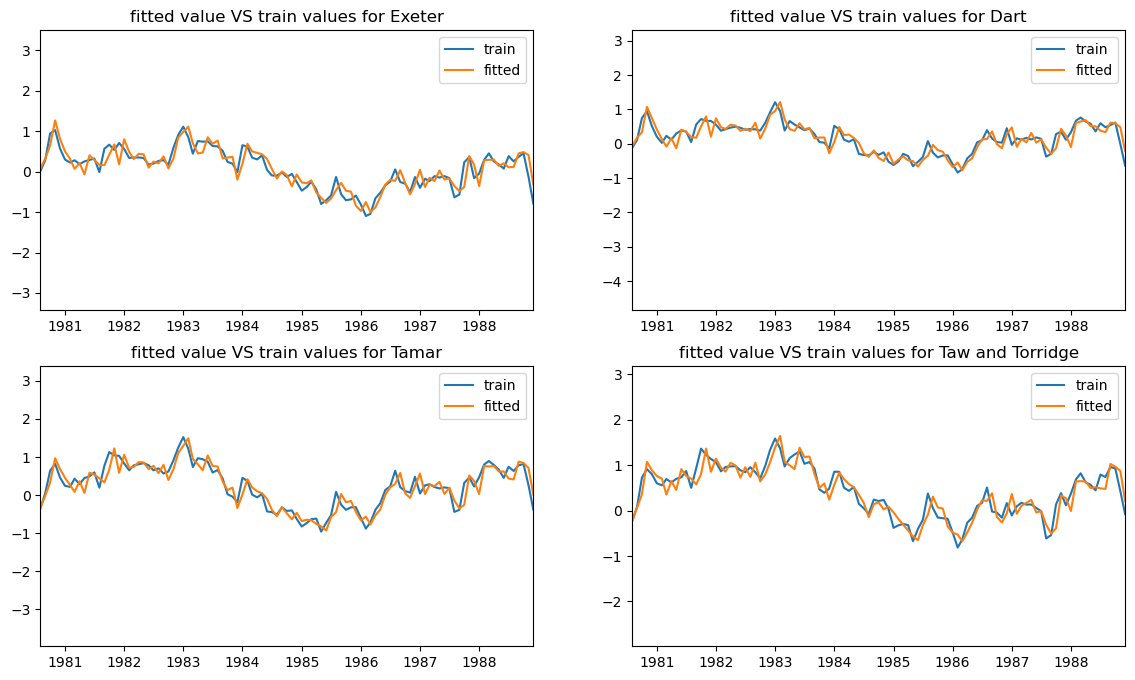

In [18]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 8))
grid = [ax1, ax2, ax3, ax4]

for i, (key, value) in enumerate(area.items()):
    grid[i].plot(train[key], label='train')
    grid[i].plot(arima_result[key].fittedvalues, label='fitted')
    grid[i].legend()
    grid[i].set_xlim(spi[key].index[1400], spi[key].index[1500])
    grid[i].set_title(f'fitted value VS train values for {key}')
    


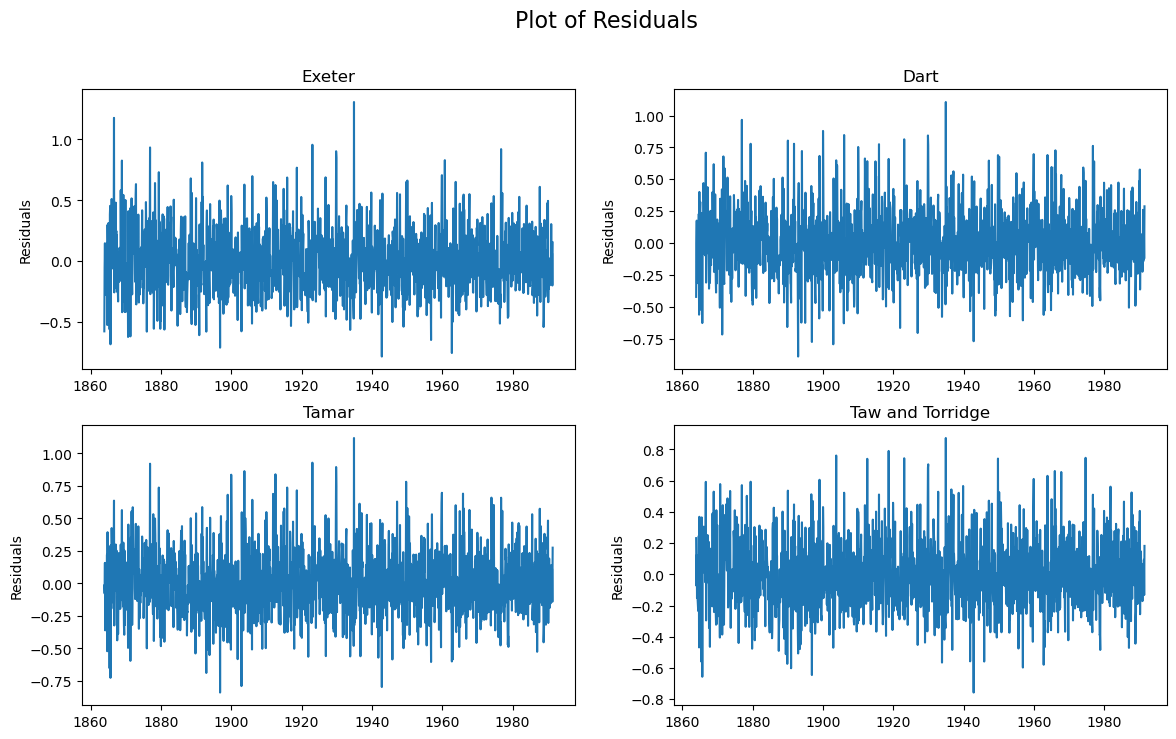

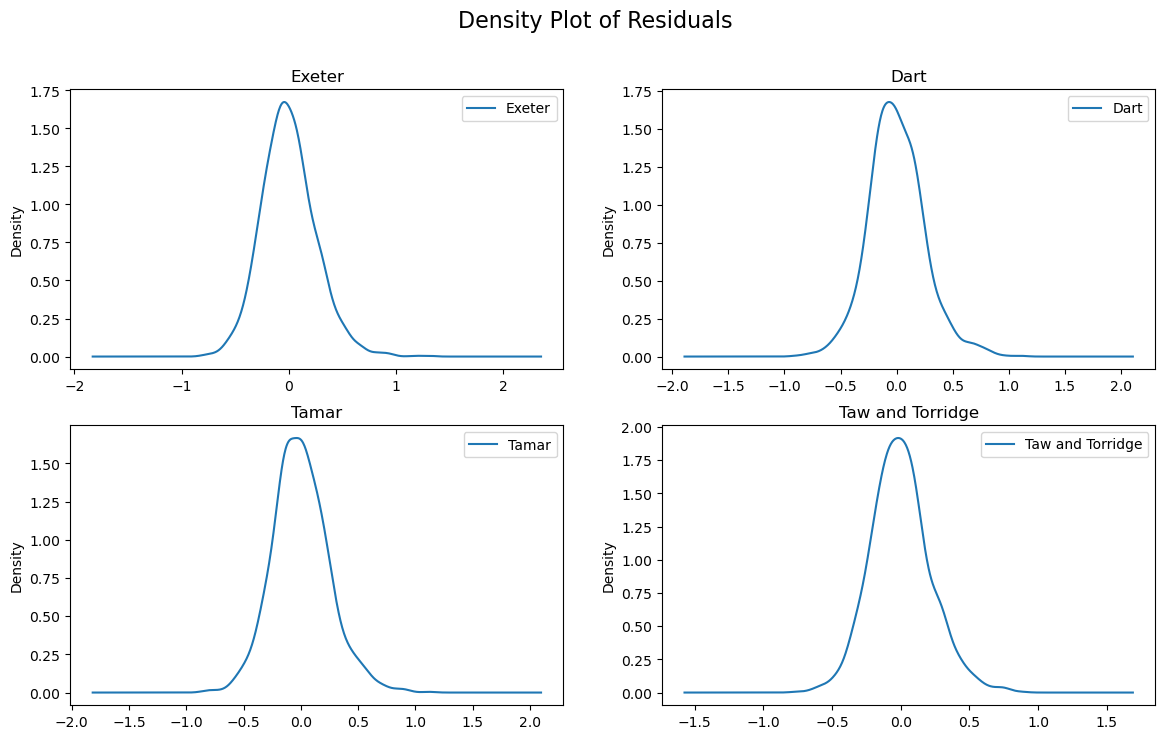

            Exeter         Dart        Tamar  Taw and Torridge
count  1531.000000  1531.000000  1531.000000       1531.000000
mean      0.000374     0.000253     0.000115          0.000212
std       0.253622     0.250017     0.247366          0.218949
min      -0.783197    -0.891471    -0.839490         -0.757348
25%      -0.170867    -0.160056    -0.160659         -0.141683
50%      -0.015110    -0.011762    -0.014374         -0.011536
75%       0.148042     0.150385     0.146363          0.121474
max       1.307564     1.106271     1.117909          0.873474


In [19]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 8))
grid = [ax1, ax2, ax3, ax4]
residuals = pd.DataFrame()

# line plot of residuals
for i, (key, value) in enumerate(area.items()):
    residuals[key] = arima_result[key].resid
    
    grid[i].plot(residuals[key])
    grid[i].set_ylabel('Residuals')
    grid[i].set_title(key)
fig.suptitle('Plot of Residuals', fontsize=16)
plt.show()


# density plot of residuals
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 8))
grid = [ax1, ax2, ax3, ax4]
for i, (key, value) in enumerate(area.items()):
    residuals[[key]].plot(kind='kde', ax = grid[i])
    grid[i].set_title(key)
fig.suptitle('Density Plot of Residuals', fontsize=16)
plt.show()

# summary stats of residuals
print(residuals.describe())

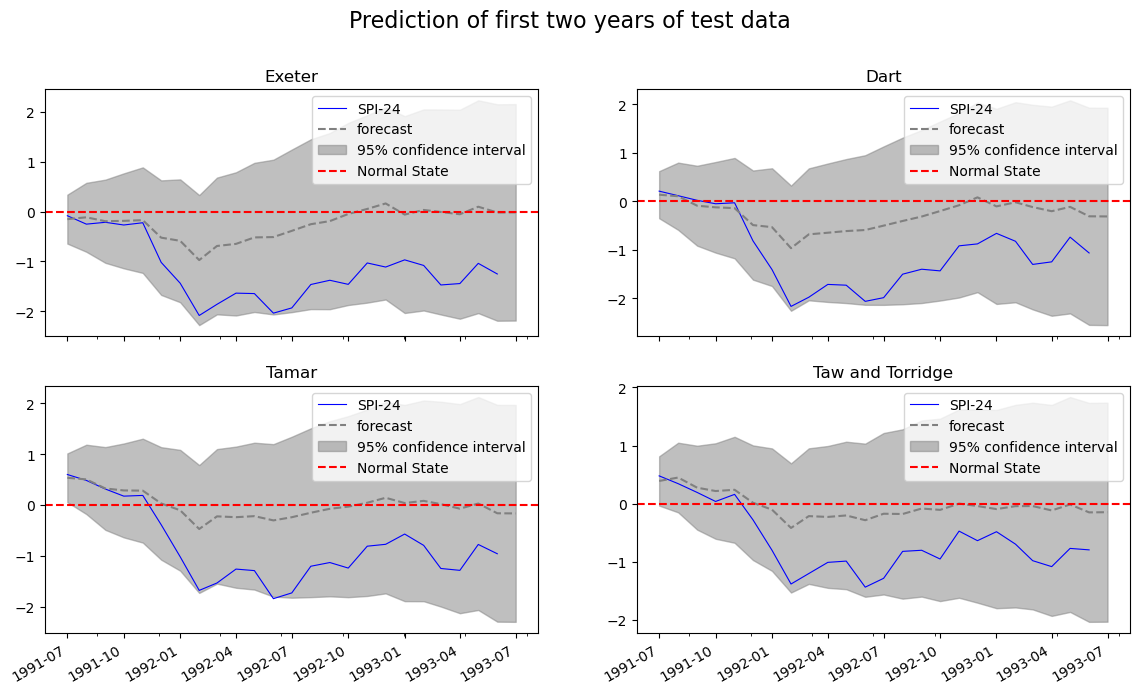

In [20]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 8), sharex=True)
grid = [ax1, ax2, ax3, ax4]
for i, (key, value) in enumerate(area.items()):
    grid[i].plot(value['date'][1531:1555], value['spi-24'][1531:1555], color='blue', linewidth=0.8, label= 'SPI-24')
    plot_predict(arima_result[key], start=1531, end=1555, ax=grid[i], label='forecast')
    line = grid[i].lines[1]  # Get the line object
    line.set_linewidth(1.5)  
    line.set_linestyle('--')
    line.set_color('gray')
    grid[i].axhline(y=0, color='red', linestyle='--', label='Normal State')
    grid[i].set_title(key)
    grid[i].set_xlabel('')  
    grid[i].legend()
fig.suptitle('Prediction of first two years of test data', fontsize=16)
plt.show()


## Validating ARIMA model

In [21]:
X = {}
train = {}
test = {}
arima_preds = {}
history = {}
predictions = list()

for key in area.keys():
    X[key] = spi[key].values
    train[key], test[key] = X[key][0:size], X[key][size:len(X[key])]
    history[key] = [x for x in train[key]]

In [22]:
# walk-forward validation

for key in area.keys():
    predictions = []
    for t in range(iterations):
        model = ARIMA(history[key], order=(2, 0, 24))
        model_fit = model.fit()
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = test[key][t]
        print('%f- predicted=%f, expected=%f' % (math.floor(t), yhat, obs))
        history[key].append(yhat)
    arima_preds[key] = predictions

C:\Users\ADMIN\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.000000- predicted=-0.151616, expected=-0.083000


C:\Users\ADMIN\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1.000000- predicted=-0.113977, expected=-0.252000


C:\Users\ADMIN\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


2.000000- predicted=-0.193755, expected=-0.215000


C:\Users\ADMIN\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


3.000000- predicted=-0.190934, expected=-0.269000


C:\Users\ADMIN\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


4.000000- predicted=-0.180207, expected=-0.224000


C:\Users\ADMIN\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


5.000000- predicted=-0.531655, expected=-1.018000


C:\Users\ADMIN\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


6.000000- predicted=-0.597436, expected=-1.436000


C:\Users\ADMIN\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


7.000000- predicted=-0.983674, expected=-2.083000


C:\Users\ADMIN\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


8.000000- predicted=-0.698154, expected=-1.859000


C:\Users\ADMIN\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


9.000000- predicted=-0.655789, expected=-1.635000


C:\Users\ADMIN\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


10.000000- predicted=-0.525675, expected=-1.644000


C:\Users\ADMIN\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


11.000000- predicted=-0.515783, expected=-2.036000


C:\Users\ADMIN\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


12.000000- predicted=-0.394232, expected=-1.931000


C:\Users\ADMIN\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


13.000000- predicted=-0.259977, expected=-1.462000


C:\Users\ADMIN\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


14.000000- predicted=-0.198822, expected=-1.377000


C:\Users\ADMIN\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


15.000000- predicted=-0.054836, expected=-1.459000


C:\Users\ADMIN\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


16.000000- predicted=0.047024, expected=-1.030000


C:\Users\ADMIN\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


17.000000- predicted=0.158557, expected=-1.112000


C:\Users\ADMIN\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


18.000000- predicted=-0.064217, expected=-0.968000


C:\Users\ADMIN\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


19.000000- predicted=0.030509, expected=-1.080000


C:\Users\ADMIN\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


20.000000- predicted=-0.010871, expected=-1.471000


C:\Users\ADMIN\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


21.000000- predicted=-0.057170, expected=-1.443000


C:\Users\ADMIN\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


22.000000- predicted=0.094160, expected=-1.038000


C:\Users\ADMIN\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


23.000000- predicted=-0.021287, expected=-1.251000


C:\Users\ADMIN\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.000000- predicted=0.134675, expected=0.208000


C:\Users\ADMIN\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1.000000- predicted=0.103842, expected=0.114000


C:\Users\ADMIN\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


2.000000- predicted=-0.088437, expected=0.019000


C:\Users\ADMIN\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


3.000000- predicted=-0.123019, expected=-0.052000


C:\Users\ADMIN\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


4.000000- predicted=-0.141339, expected=-0.032000


C:\Users\ADMIN\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


5.000000- predicted=-0.488754, expected=-0.817000


C:\Users\ADMIN\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


6.000000- predicted=-0.526881, expected=-1.408000


C:\Users\ADMIN\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


7.000000- predicted=-0.960938, expected=-2.167000


C:\Users\ADMIN\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


8.000000- predicted=-0.677266, expected=-1.978000


C:\Users\ADMIN\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


9.000000- predicted=-0.642454, expected=-1.714000


C:\Users\ADMIN\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


10.000000- predicted=-0.607351, expected=-1.730000


C:\Users\ADMIN\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


11.000000- predicted=-0.585575, expected=-2.063000


C:\Users\ADMIN\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


12.000000- predicted=-0.497761, expected=-1.987000


C:\Users\ADMIN\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


13.000000- predicted=-0.401991, expected=-1.503000


C:\Users\ADMIN\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


14.000000- predicted=-0.311027, expected=-1.401000


C:\Users\ADMIN\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


15.000000- predicted=-0.199941, expected=-1.435000


C:\Users\ADMIN\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


16.000000- predicted=-0.081117, expected=-0.919000


C:\Users\ADMIN\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


17.000000- predicted=0.084938, expected=-0.879000


C:\Users\ADMIN\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


18.000000- predicted=-0.102091, expected=-0.662000


C:\Users\ADMIN\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


19.000000- predicted=-0.013974, expected=-0.825000


C:\Users\ADMIN\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


20.000000- predicted=-0.108498, expected=-1.302000


C:\Users\ADMIN\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


21.000000- predicted=-0.192460, expected=-1.249000


C:\Users\ADMIN\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


22.000000- predicted=-0.103866, expected=-0.740000


C:\Users\ADMIN\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


23.000000- predicted=-0.297485, expected=-1.066000


C:\Users\ADMIN\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.000000- predicted=0.536237, expected=0.601000


C:\Users\ADMIN\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1.000000- predicted=0.505020, expected=0.485000


C:\Users\ADMIN\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


2.000000- predicted=0.326880, expected=0.315000


C:\Users\ADMIN\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


3.000000- predicted=0.288341, expected=0.175000


C:\Users\ADMIN\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


4.000000- predicted=0.283698, expected=0.189000


C:\Users\ADMIN\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


5.000000- predicted=0.032131, expected=-0.388000


C:\Users\ADMIN\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


6.000000- predicted=-0.107671, expected=-1.020000


C:\Users\ADMIN\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


7.000000- predicted=-0.478445, expected=-1.682000


C:\Users\ADMIN\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


8.000000- predicted=-0.229667, expected=-1.536000


C:\Users\ADMIN\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


9.000000- predicted=-0.245853, expected=-1.262000


C:\Users\ADMIN\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


10.000000- predicted=-0.227474, expected=-1.292000


C:\Users\ADMIN\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


11.000000- predicted=-0.310373, expected=-1.845000


C:\Users\ADMIN\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


12.000000- predicted=-0.250685, expected=-1.731000


C:\Users\ADMIN\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


13.000000- predicted=-0.163015, expected=-1.206000


C:\Users\ADMIN\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


14.000000- predicted=-0.085550, expected=-1.133000


C:\Users\ADMIN\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


15.000000- predicted=-0.041641, expected=-1.242000


C:\Users\ADMIN\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


16.000000- predicted=0.036298, expected=-0.811000


C:\Users\ADMIN\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


17.000000- predicted=0.136892, expected=-0.774000


C:\Users\ADMIN\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


18.000000- predicted=0.031753, expected=-0.572000


C:\Users\ADMIN\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


19.000000- predicted=0.079391, expected=-0.795000


C:\Users\ADMIN\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


20.000000- predicted=0.017330, expected=-1.250000


C:\Users\ADMIN\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


21.000000- predicted=-0.072025, expected=-1.287000


C:\Users\ADMIN\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


22.000000- predicted=0.028775, expected=-0.777000


C:\Users\ADMIN\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


23.000000- predicted=-0.155900, expected=-0.960000


C:\Users\ADMIN\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.000000- predicted=0.391574, expected=0.479000


C:\Users\ADMIN\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1.000000- predicted=0.449210, expected=0.345000


C:\Users\ADMIN\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


2.000000- predicted=0.274510, expected=0.194000


C:\Users\ADMIN\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


3.000000- predicted=0.211799, expected=0.039000


C:\Users\ADMIN\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


4.000000- predicted=0.239646, expected=0.161000


C:\Users\ADMIN\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


5.000000- predicted=0.017146, expected=-0.277000


C:\Users\ADMIN\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


6.000000- predicted=-0.084026, expected=-0.800000


C:\Users\ADMIN\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


7.000000- predicted=-0.403391, expected=-1.380000


C:\Users\ADMIN\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


8.000000- predicted=-0.201633, expected=-1.200000


C:\Users\ADMIN\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


9.000000- predicted=-0.218401, expected=-1.008000


C:\Users\ADMIN\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


10.000000- predicted=-0.191381, expected=-0.986000


C:\Users\ADMIN\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


11.000000- predicted=-0.272186, expected=-1.434000


C:\Users\ADMIN\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


12.000000- predicted=-0.159943, expected=-1.282000


C:\Users\ADMIN\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


13.000000- predicted=-0.161376, expected=-0.819000


C:\Users\ADMIN\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


14.000000- predicted=-0.073711, expected=-0.800000


C:\Users\ADMIN\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


15.000000- predicted=-0.095599, expected=-0.950000


C:\Users\ADMIN\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


16.000000- predicted=0.011036, expected=-0.471000


C:\Users\ADMIN\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


17.000000- predicted=-0.030691, expected=-0.635000


C:\Users\ADMIN\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


18.000000- predicted=-0.082055, expected=-0.481000


C:\Users\ADMIN\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


19.000000- predicted=-0.031529, expected=-0.695000


C:\Users\ADMIN\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


20.000000- predicted=-0.026762, expected=-0.979000


C:\Users\ADMIN\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


21.000000- predicted=-0.105143, expected=-1.081000


C:\Users\ADMIN\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


22.000000- predicted=-0.004183, expected=-0.768000


C:\Users\ADMIN\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


23.000000- predicted=-0.129961, expected=-0.793000


In [23]:
# evaluate forecasts
print('RMES Result:')
arima_rmse ={}
for key in area.keys():
    arima_rmse[key] = math.sqrt(mean_squared_error(test[key][:24], arima_preds[key]))
    print(f'{key} Test RMSE: {arima_rmse[key]}')
    
print('MAE Result:')
arima_mae ={}
for key in area.keys():
    arima_mae[key] = mean_absolute_error(test[key][:24], arima_preds[key])
    print(f'{key} Test MAE: {arima_mae[key]}')

    
    

RMES Result:
Exeter Test RMSE: 1.0584130468404624
Dart Test RMSE: 0.9340307848245918
Tamar Test RMSE: 0.9483169715066662
Taw and Torridge Test RMSE: 0.7142402616033289
MAE Result:
Exeter Test MAE: 0.9351422693274088
Dart Test MAE: 0.8125744508604861
Tamar Test MAE: 0.8275821563207151
Taw and Torridge Test MAE: 0.6299500945923754


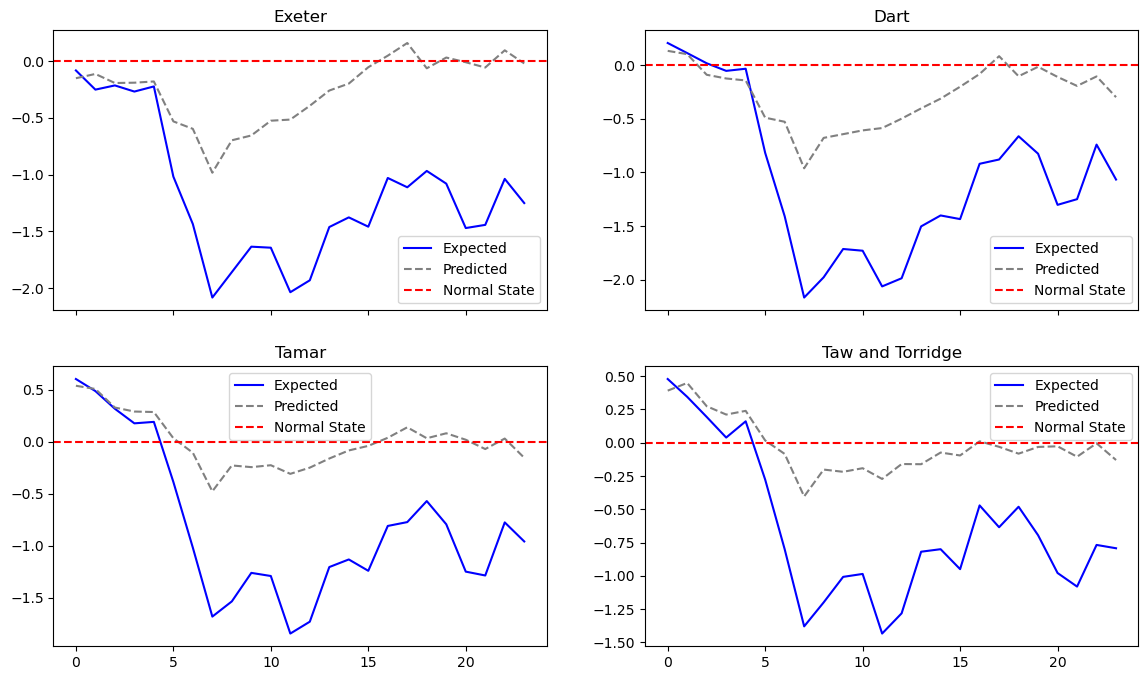

In [24]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 8), sharex=True)
grid = [ax1, ax2, ax3, ax4]
for i, ((key1, value1),(key2, value2)) in enumerate(zip(test.items(), arima_preds.items())):
    grid[i].plot(value1[:24], color='blue', label='Expected')
#     grid[i].scatter(value1[:24], color='red', label='Expected')
    grid[i].plot(value2, color='gray', label='Predicted', linestyle='--')
    grid[i].axhline(y=0, color='red', linestyle='--', label='Normal State')
    grid[i].set_title(key1)
    grid[i].legend()
plt.show()

# LSTM

In [25]:
# function definition:

#======================================================================================
def timeseries_to_supervised(data, lag=1):
    """
    Transform a time series data into a supervised learning problem by creating lagged observations.

    Parameters:
    - data (numpy.ndarray or list): The input time series data.
    - lag (int): The number of lag observations to use for each time step. Default is 1.

    Returns:
    - pd.DataFrame: A DataFrame containing the original data and lagged observations.
    """
    df = pd.DataFrame(data)  
    columns = [df.shift(i) for i in range(1, lag + 1)]  # Shift the data to create lagged observations
    columns.append(df)  # Include the original data as a column
    df = pd.concat(columns, axis=1)  # Concatenate the lagged observations and original data horizontally
    df.fillna(0, inplace=True) 
    return df
#======================================================================================
def fit_lstm(train, batch_size, nb_epoch, neurons):
    """
    Fit an LSTM network to training data.

    Args:
        train (numpy.ndarray): Training data containing both features and target.
        batch_size (int): Batch size for training the LSTM.
        nb_epoch (int): Number of epochs to train the LSTM.
        neurons (int): Number of neurons in the LSTM layer.

    Returns:
        keras.models.Sequential: Trained LSTM model.
    """
    X, y = train[:, 0:-1], train[:, -1]  
    X = X.reshape(X.shape[0], 1, X.shape[1])  
    
    # Create a Sequential model
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))    
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    
    # Train the model for the specified number of epochs
    for i in range(nb_epoch):
        # Fit the model on the training data for one epoch
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)       
        model.reset_states()
    
    return model
#======================================================================================
def forecast_lstm(model, batch_size, X):
    """
    Make a one-step forecast using an LSTM model.

    Args:
        model (keras.models.Sequential): Trained LSTM model.
        batch_size (int): Batch size for making the forecast.
        X (numpy.ndarray): Input features for the forecast.

    Returns:
        float: One-step forecasted value.
    """
    X = X.reshape(1, 1, len(X))  # Reshape input features for the forecast
    yhat = model.predict(X, batch_size=batch_size)  # Predict using the LSTM model
    return yhat[0, 0]  # Extract the forecasted value from the prediction
#======================================================================================
def walk_forward_validation(area, test, spi, model, iterations):
    """
    Perform walk-forward validation on the test data using LSTM models.

    Args:
        area (dict): A dictionary containing the areas for which validation needs to be performed.
        test (dict): A dictionary containing the test data for each area.
        spi (dict): A dictionary containing the spi for each area.
        model (dict): A dictionary containing the LSTM models for each area.
        iterations (int): The number of iterations for the walk-forward validation.

    Returns:
        dict: A dictionary containing the predictions for each area.
    """
    preds = {}  
    

    for key in area.keys():
        predictions = []  
        for i in range(iterations):
            X, y = test[key][i, 0:-1], test[key][i, -1]           
            # Make a one-step forecast using the LSTM model
            yhat = forecast_lstm(model[key], 1, X)
            predictions.append(yhat)  # Store the predicted value
            expected = spi[key][len(train_lstm[key]) + i ]
            print('Month=%d, Predicted=%f, Expected=%f' % (i , yhat, expected))        
        # Store the predictions for the current area
        preds[key] = predictions
    
    return preds
#======================================================================================
def report_performance(preds, spi, start_index, end_index):
    """
    Report performance by calculating RMSE for each area's predictions.

    Args:
        preds (dict): A dictionary containing the LSTM predictions for each area.
        spi (dict): A dictionary containing the spi for each area.
        start_index (int): Starting index for calculating RMSE.
        end_index (int): Ending index (exclusive) for calculating RMSE.
    """
    rmse = {}  # Initialize a dictionary to store RMSE values for each area
    
    # Iterate through each area's predictions
    for key, value in preds.items():
        rmse[key] = math.sqrt(mean_squared_error(spi[key][start_index:end_index], value))
        print(f'{key}: Test RMSE:  {rmse[key]}')
    return rmse
#======================================================================================

In [26]:
series = {}
for key, value in area.items():
    series[key] = pd.Series(value['spi-24'].values) 
    series[key].index = value['date']

In [27]:
raw_values = {}
supervised = {}
supervised_values ={}
size = 1530 # train size which roughly 80 percent of whole date

for key, value in series.items():
    raw_values[key] = value.values
    supervised[key] = timeseries_to_supervised(raw_values[key], 1)
    supervised_values[key] = supervised[key].values

train_lstm ={}
test_lstm = {}
for key, value in supervised_values.items():
    train_lstm[key], test_lstm[key] = value[0:size], value[size:]

In [28]:
lstm_model = {}
train_reshaped = {}
for key, value in train_lstm.items():
    # fit the model
    lstm_model[key] = fit_lstm(value, 1, 24, 4) 
    # forecast the entire training dataset to build up state for forecasting
    train_reshaped[key] = value[:, 0].reshape(len(value), 1, 1)
    lstm_model[key].predict(train_reshaped[key], batch_size=1)

1530/1530 [==============================] - 3s 2ms/step


In [29]:
# walk-forward validation on test data

lstm_preds = walk_forward_validation(area, test_lstm, raw_values, lstm_model, iterations)


1/1 [==============================] - 0s 32ms/step
Month=0, Predicted=-0.524958, Expected=-0.210000
1/1 [==============================] - 0s 27ms/step
Month=1, Predicted=-0.175910, Expected=-0.083000
1/1 [==============================] - 0s 34ms/step
Month=2, Predicted=-0.082427, Expected=-0.252000
1/1 [==============================] - 0s 26ms/step
Month=3, Predicted=-0.267002, Expected=-0.215000
1/1 [==============================] - 0s 25ms/step
Month=4, Predicted=-0.196866, Expected=-0.269000
1/1 [==============================] - 0s 26ms/step
Month=5, Predicted=-0.274930, Expected=-0.224000
1/1 [==============================] - 0s 25ms/step
Month=6, Predicted=-0.212570, Expected=-1.018000
1/1 [==============================] - 0s 24ms/step
Month=7, Predicted=-1.071743, Expected=-1.436000
1/1 [==============================] - 0s 38ms/step
Month=8, Predicted=-1.332145, Expected=-2.083000
1/1 [==============================] - 0s 40ms/step
Month=9, Predicted=-1.853376, Expected=

1/1 [==============================] - 0s 29ms/step
Month=9, Predicted=-1.167427, Expected=-1.200000
1/1 [==============================] - 0s 25ms/step
Month=10, Predicted=-1.098120, Expected=-1.008000
1/1 [==============================] - 0s 25ms/step
Month=11, Predicted=-0.935465, Expected=-0.986000
1/1 [==============================] - 0s 28ms/step
Month=12, Predicted=-0.904945, Expected=-1.434000
1/1 [==============================] - 0s 30ms/step
Month=13, Predicted=-1.257015, Expected=-1.282000
1/1 [==============================] - 0s 26ms/step
Month=14, Predicted=-1.231586, Expected=-0.819000
1/1 [==============================] - 0s 31ms/step
Month=15, Predicted=-0.842436, Expected=-0.800000
1/1 [==============================] - 0s 30ms/step
Month=16, Predicted=-0.812293, Expected=-0.950000
1/1 [==============================] - 0s 31ms/step
Month=17, Predicted=-0.960959, Expected=-0.471000
1/1 [==============================] - 0s 28ms/step
Month=18, Predicted=-0.440169, 

## Evaluating LSTM model

In [30]:
# report performance
rmse = report_performance(lstm_preds, raw_values, 1529, 1553)

Exeter: Test RMSE:  0.11517990798102147
Dart: Test RMSE:  0.09142928071886702
Tamar: Test RMSE:  0.12321748295226681
Taw and Torridge: Test RMSE:  0.07165628817684969


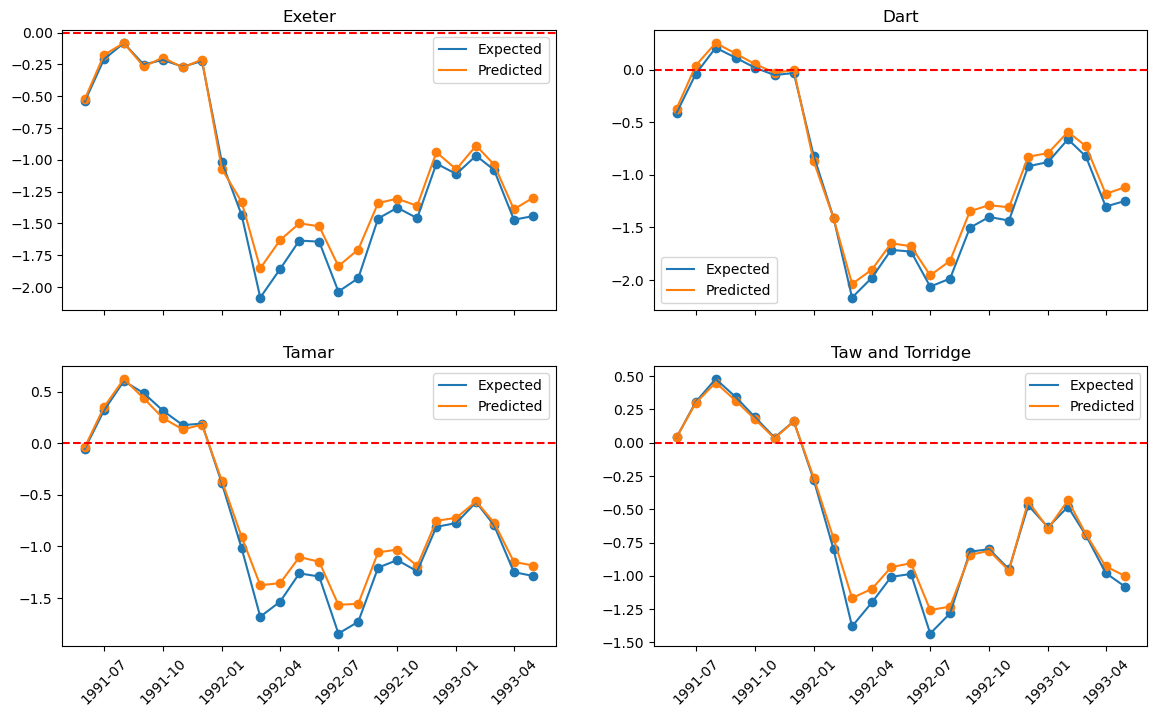

In [31]:
# line plot of observed vs predicted
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 8), sharex=True)
grid = [ax1, ax2, ax3, ax4]
for i, ((key1, value1), (key2, value2)) in enumerate(zip(raw_values.items(), lstm_preds.items())):
    grid[i].plot(series[key1][1530:1554].index, value1[1529:1553], label='Expected')
    grid[i].scatter(series[key1][1530:1554].index, value1[1529:1553])
    grid[i].plot(series[key1][1530:1554].index, value2, label='Predicted')
    grid[i].scatter(series[key1][1530:1554].index, value2)
#     grid[i].set_xlim(pd.to_datetime('1991-06-01'), pd.to_datetime('1993-07-01'))
    grid[i].axhline(0, linestyle='--', color='red')
    grid[i].tick_params(axis='x', rotation=45)
    grid[i].set_title(key1)
    grid[i].legend()
plt.show()


I'm adding dropout to my LSTM model because I want to make sure it doesn't get too fixated on the training data. 

By including dropout in my `fit_lstm` function, I'm essentially giving my model a way to learn more flexibly. This means that the model can't rely on just one neuron.

actually I want to improve the model's ability to generalize so my LSTM model to understand the broader patterns in the data, not just memorize the examples it has seen during training.


In [32]:
def fit_lstm_improved(train, batch_size, nb_epoch, neurons, dropout_rate ):
    
    X, y = train[:, 0:-1], train[:, -1]  
    X = X.reshape(X.shape[0], 1, X.shape[1])  
    
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True)) 
    model.add(Dropout(dropout_rate))  # Add dropout layer
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)       
        model.reset_states()
    
    return model

In [33]:
batch_size = 1
nb_epoch = 24
neurons = 4
dropout_rate = 0.6 

In [34]:
lstm_model = {}
train_reshaped = {}
for key, value in train_lstm.items():
    # fit the model
    lstm_model[key] = fit_lstm_improved(value, batch_size, nb_epoch, neurons, dropout_rate) 
    # forecast the entire training dataset to build up state for forecasting
    train_reshaped[key] = value[:, 0].reshape(len(value), 1, 1)
    lstm_model[key].predict(train_reshaped[key], batch_size=1)

1530/1530 [==============================] - 3s 1ms/step


In [35]:
lstm_preds = walk_forward_validation(area, test_lstm, raw_values, lstm_model, iterations)

1/1 [==============================] - 0s 27ms/step
Month=0, Predicted=-0.391102, Expected=-0.210000
1/1 [==============================] - 0s 25ms/step
Month=1, Predicted=-0.123914, Expected=-0.083000
1/1 [==============================] - 0s 24ms/step
Month=2, Predicted=-0.066113, Expected=-0.252000
1/1 [==============================] - 0s 35ms/step
Month=3, Predicted=-0.213849, Expected=-0.215000
1/1 [==============================] - 0s 35ms/step
Month=4, Predicted=-0.160474, Expected=-0.269000
1/1 [==============================] - 0s 34ms/step
Month=5, Predicted=-0.210787, Expected=-0.224000
1/1 [==============================] - 0s 24ms/step
Month=6, Predicted=-0.166559, Expected=-1.018000
1/1 [==============================] - 0s 33ms/step
Month=7, Predicted=-0.725643, Expected=-1.436000
1/1 [==============================] - 0s 25ms/step
Month=8, Predicted=-0.973296, Expected=-2.083000
1/1 [==============================] - 0s 32ms/step
Month=9, Predicted=-1.274899, Expected=

1/1 [==============================] - 0s 27ms/step
Month=9, Predicted=-1.018227, Expected=-1.200000
1/1 [==============================] - 0s 26ms/step
Month=10, Predicted=-0.905878, Expected=-1.008000
1/1 [==============================] - 0s 25ms/step
Month=11, Predicted=-0.778579, Expected=-0.986000
1/1 [==============================] - 0s 24ms/step
Month=12, Predicted=-0.759754, Expected=-1.434000
1/1 [==============================] - 0s 24ms/step
Month=13, Predicted=-1.051182, Expected=-1.282000
1/1 [==============================] - 0s 25ms/step
Month=14, Predicted=-0.958161, Expected=-0.819000
1/1 [==============================] - 0s 37ms/step
Month=15, Predicted=-0.628286, Expected=-0.800000
1/1 [==============================] - 0s 26ms/step
Month=16, Predicted=-0.623394, Expected=-0.950000
1/1 [==============================] - 0s 26ms/step
Month=17, Predicted=-0.734187, Expected=-0.471000
1/1 [==============================] - 0s 26ms/step
Month=18, Predicted=-0.342815, 

In [36]:
rmse = report_performance(lstm_preds, raw_values, 1529, 1553)

Exeter: Test RMSE:  0.43203793024960346
Dart: Test RMSE:  0.36793004676783353
Tamar: Test RMSE:  0.3356404083746169
Taw and Torridge: Test RMSE:  0.1985690606297669


In [37]:
mae = {}  # Initialize a dictionary to store RMSE values for each area

# Iterate through each area's predictions
for key, value in lstm_preds.items():
    mae[key] = mean_absolute_error(raw_values[key][1529:1553], value)
    print(f'{key}: Test MAE:  {mae[key]}')



Exeter: Test MAE:  0.3654269885867835
Dart: Test MAE:  0.29871283612648647
Tamar: Test MAE:  0.290315552632014
Taw and Torridge: Test MAE:  0.17347126683592795


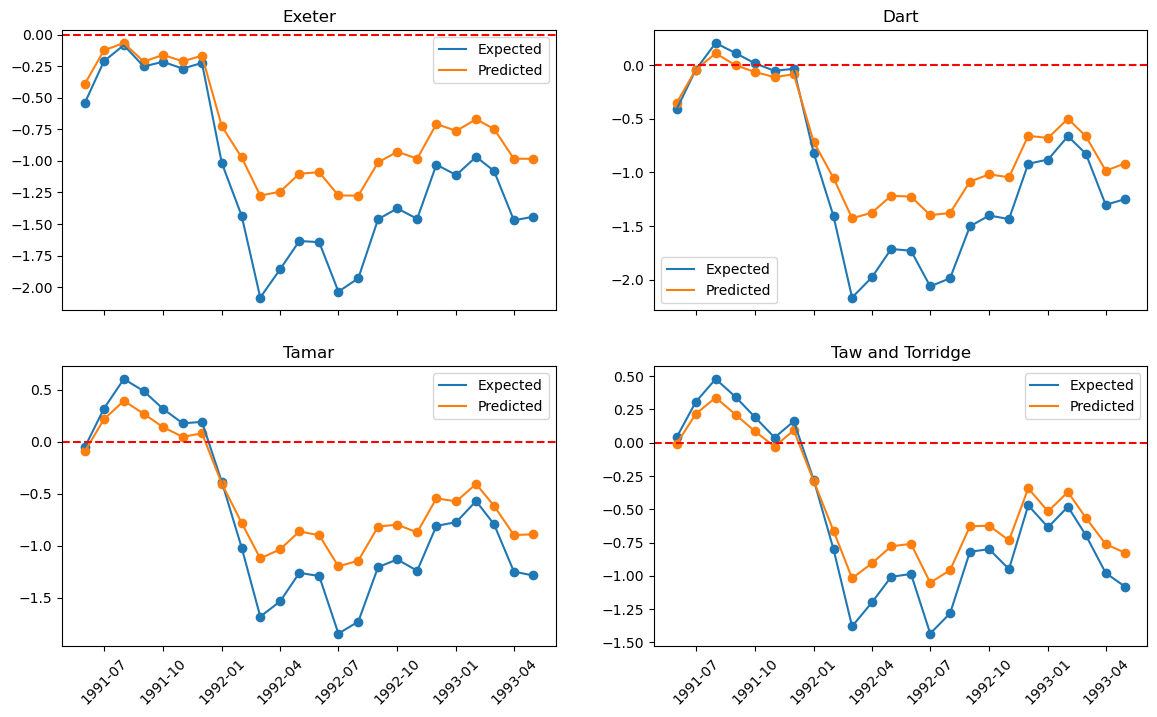

In [38]:
# line plot of observed vs predicted
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 8), sharex=True)
grid = [ax1, ax2, ax3, ax4]
for i, ((key1, value1), (key2, value2)) in enumerate(zip(raw_values.items(), lstm_preds.items())):
    grid[i].plot(series[key1][1530:1554].index, value1[1529:1553], label='Expected')
    grid[i].scatter(series[key1][1530:1554].index, value1[1529:1553])
    grid[i].plot(series[key1][1530:1554].index, value2, label='Predicted')
    grid[i].scatter(series[key1][1530:1554].index, value2)
#     grid[i].set_xlim(pd.to_datetime('1991-06-01'), pd.to_datetime('1993-07-01'))
    grid[i].axhline(0, linestyle='--', color='red')
    grid[i].tick_params(axis='x', rotation=45)
    grid[i].set_title(key1)
    grid[i].legend()
plt.show()

# Compare

In [39]:
df_metrics = pd.DataFrame({'LSTM_RMSE':rmse, 'ARIMA_RMSE':arima_rmse, 
                        'LSTM_MAE':mae, 'ARIMA_MAE':arima_mae})
print(' ' * 20, 'LSTM VS ARIMA metrics\n\n', df_metrics, sep='')

                    LSTM VS ARIMA metrics

                  LSTM_RMSE  ARIMA_RMSE  LSTM_MAE  ARIMA_MAE
Exeter             0.432038    1.058413  0.365427   0.935142
Dart               0.367930    0.934031  0.298713   0.812574
Tamar              0.335640    0.948317  0.290316   0.827582
Taw and Torridge   0.198569    0.714240  0.173471   0.629950


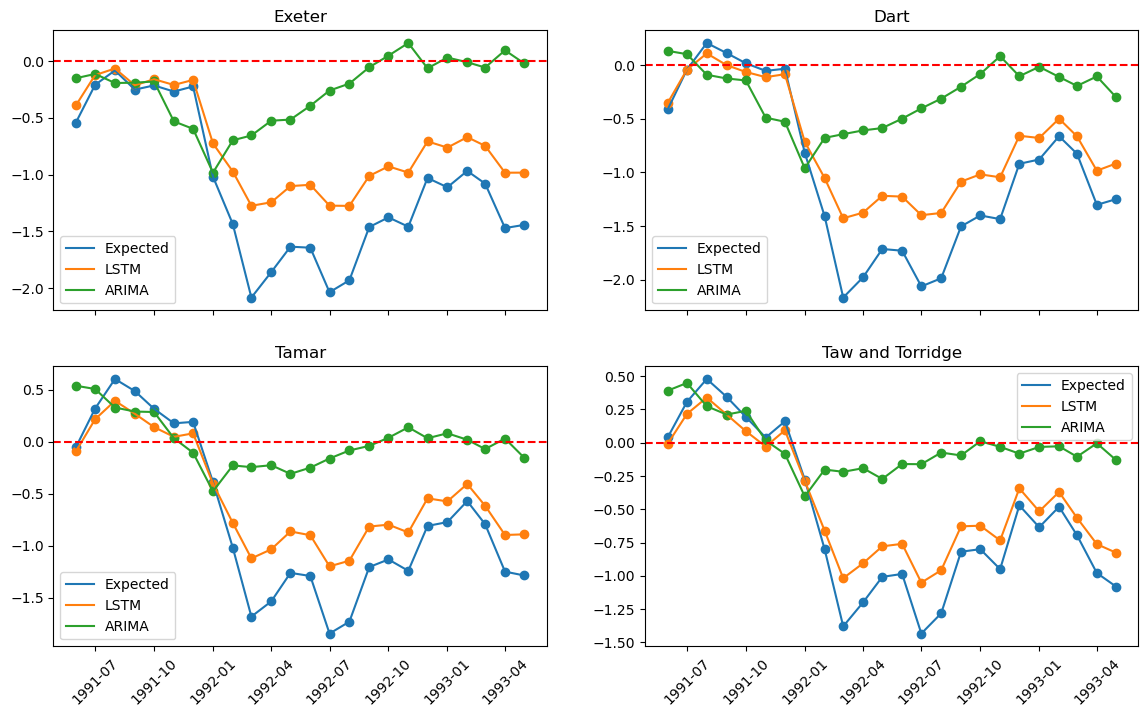

In [40]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 8), sharex=True)
grid = [ax1, ax2, ax3, ax4]
for i, ((key1, value1), (key2, value2), (key3, value3)) in enumerate(zip(raw_values.items(), 
                                                                         lstm_preds.items(),
                                                                         arima_preds.items())):
    grid[i].plot(series[key1][1530:1554].index, value1[1529:1553], label='Expected')
    grid[i].scatter(series[key1][1530:1554].index, value1[1529:1553])
    grid[i].plot(series[key1][1530:1554].index, value2, label='LSTM')
    grid[i].scatter(series[key1][1530:1554].index, value2)
    grid[i].plot(series[key1][1530:1554].index, value3, label='ARIMA')
    grid[i].scatter(series[key1][1530:1554].index, value3)
    grid[i].axhline(0, linestyle='--', color='red')
    grid[i].tick_params(axis='x', rotation=45)
    grid[i].set_title(key1)
    grid[i].legend()
plt.show()

calculation of metrics in just first 8 month of test data

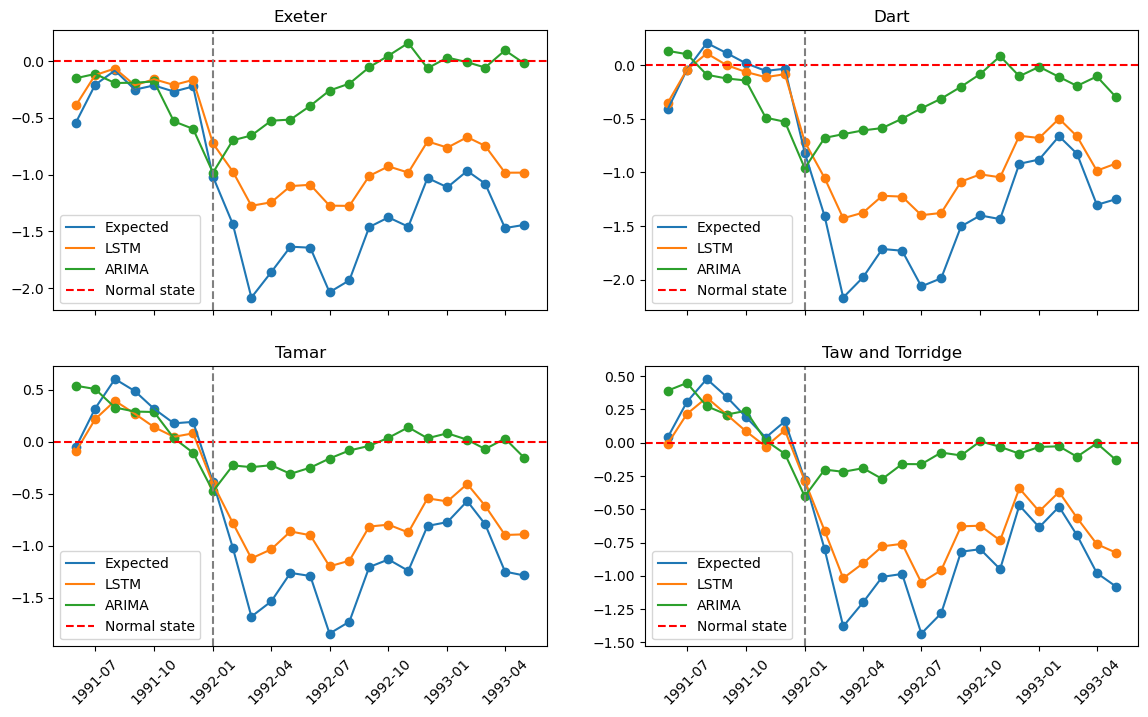

In [42]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 8), sharex=True)
grid = [ax1, ax2, ax3, ax4]
for i, ((key1, value1), (key2, value2), (key3, value3)) in enumerate(zip(raw_values.items(), 
                                                                         lstm_preds.items(),
                                                                         arima_preds.items())):
    grid[i].plot(series[key1][1530:1554].index, value1[1529:1553], label='Expected')
    grid[i].scatter(series[key1][1530:1554].index, value1[1529:1553])
    grid[i].plot(series[key1][1530:1554].index, value2, label='LSTM')
    grid[i].scatter(series[key1][1530:1554].index, value2)
    grid[i].plot(series[key1][1530:1554].index, value3, label='ARIMA')
    grid[i].scatter(series[key1][1530:1554].index, value3)
    grid[i].axhline(0, linestyle='--', color='red', label='Normal state')
    grid[i].axvline(pd.to_datetime('1992-01-01'), linestyle='--', color='gray')
    grid[i].tick_params(axis='x', rotation=45)
    grid[i].set_title(key1)
    grid[i].legend()
plt.show()

In [43]:
# evaluate forecasts
print('RMES Result:')
arima_rmse ={}
for key in area.keys():
    arima_rmse[key] = math.sqrt(mean_squared_error(test[key][:8], arima_preds[key][:8]))
    print(f'{key} Test RMSE: {arima_rmse[key]}')
    
print('MAE Result:')
arima_mae ={}
for key in area.keys():
    arima_mae[key] = mean_absolute_error(test[key][:8], arima_preds[key][:8])
    print(f'{key} Test MAE: {arima_mae[key]}')

RMES Result:
Exeter Test RMSE: 0.5220705077976794
Dart Test RMSE: 0.5446010862243815
Tamar Test RMSE: 0.5572194026577767
Taw and Torridge Test RMSE: 0.4491568017118677
MAE Result:
Exeter Test MAE: 0.34674718671285254
Dart Test MAE: 0.34833818199380834
Tamar Test MAE: 0.3550895118043305
Taw and Torridge Test MAE: 0.313789903242954


In [45]:
mae = {}  # Initialize a dictionary to store RMSE values for each area

# Iterate through each area's predictions
for key, value in lstm_preds.items():
    mae[key] = mean_absolute_error(raw_values[key][1529:1537], value[:8])
    print(f'{key}: Test MAE:  {mae[key]}')

Exeter: Test MAE:  0.09431989385187625
Dart: Test MAE:  0.07042660650610923
Tamar: Test MAE:  0.12538700941205025
Taw and Torridge: Test MAE:  0.08282229086756705


In [47]:
rmse = {}  # Initialize a dictionary to store RMSE values for each area

# Iterate through each area's predictions
for key, value in lstm_preds.items():
    rmse[key] = math.sqrt(mean_squared_error(raw_values[key][1529:1537], value[:8]))
    print(f'{key}: Test rmse:  {rmse[key]}')

Exeter: Test rmse:  0.12602375966051135
Dart: Test rmse:  0.07817892785133516
Tamar: Test rmse:  0.1431086529689705
Taw and Torridge: Test rmse:  0.09245207932054482
